In [1]:
import numpy as np
import pandas as pd
from torch.distributions.gumbel import *
from scipy.sparse import csr_matrix
import scipy.sparse as sp
import datetime
import torch
from torch import nn, optim
import sys
import time
import random
import os
from tqdm import tqdm

C:\Users\psy62\.conda\envs\Torch_113\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\psy62\.conda\envs\Torch_113\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
import random

In [3]:
import torch.nn.functional as F

In [4]:
def seed_torch(seed=6298):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed) # if you are using multi-GPU.
    #torch.backends.cudnn.benchmark = False
    #torch.backends.cudnn.deterministic = True
    #torch.backends.cudnn.enabled = False
seed_torch()

In [5]:
#export CUDA_VISIBLE_DEVICES=0,1
cuda = torch.device('cuda:0') 
#torch.cuda.set_device(1)

# DataLoader

In [6]:
def convert_sp_mat_to_sp_tensor(X):
    coo = X.tocoo().astype(np.float32)
    row = torch.Tensor(coo.row).long()
    col = torch.Tensor(coo.col).long()
    index = torch.stack([row, col])
    data = torch.FloatTensor(coo.data)
    return torch.sparse.FloatTensor(index, data, torch.Size(coo.shape))

def getSparseGraph(n_users, m_items, Network):
    #print("generating adjacency matrix")
    adj_mat = sp.dok_matrix((n_users + m_items, n_users + m_items), dtype=np.float32)
    adj_mat = adj_mat.tolil()
    R = Network.tolil()
    adj_mat[:n_users, n_users:] = R
    adj_mat[n_users:, :n_users] = R.T
    adj_mat = adj_mat.todok()
    
    rowsum = np.array(adj_mat.sum(axis=1))
    d_inv = np.power(rowsum, -0.5).flatten()
    d_inv[np.isinf(d_inv)] = 0.
    d_mat = sp.diags(d_inv)
    
    norm_adj = d_mat.dot(adj_mat)
    norm_adj = norm_adj.dot(d_mat)
    norm_adj = norm_adj.tocsr()
    
    Graph = convert_sp_mat_to_sp_tensor(norm_adj)
    Graph = Graph.coalesce()
    return Graph

# Evaluation
def RecallPrecision_ATk(test_data, r, k):
    """
    test_data should be a list? cause users may have different amount of pos items. shape (test_batch, k)
    pred_data : shape (test_batch, k) NOTE: pred_data should be pre-sorted
    k : top-k
    """
    right_pred = r[:, :k].sum(1)
    precis_n = k
    recall_n = np.array([len(test_data[i]) for i in range(len(test_data))])
    recall = np.sum(right_pred/recall_n)
    precis = np.sum(right_pred)/precis_n
    return {'recall': recall, 'precision': precis}

def NDCGatK_r(test_data,r,k):
    """
    Normalized Discounted Cumulative Gain
    rel_i = 1 or 0, so 2^{rel_i} - 1 = 1 or 0
    """
    assert len(r) == len(test_data)
    pred_data = r[:, :k]

    test_matrix = np.zeros((len(pred_data), k))
    for i, items in enumerate(test_data):
        length = k if k <= len(items) else len(items)
        test_matrix[i, :length] = 1
    max_r = test_matrix
    idcg = np.sum(max_r * 1./np.log2(np.arange(2, k + 2)), axis=1)
    dcg = pred_data*(1./np.log2(np.arange(2, k + 2)))
    dcg = np.sum(dcg, axis=1)
    idcg[idcg == 0.] = 1.
    ndcg = dcg/idcg
    ndcg[np.isnan(ndcg)] = 0.
    return np.sum(ndcg)

def getLabel(test_data, pred_data):
    r = []
    for i in range(len(test_data)):
        groundTrue = test_data[i]
        predictTopK = pred_data[i]
        pred = list(map(lambda x: x in groundTrue, predictTopK))
        pred = np.array(pred).astype("float")
        r.append(pred)
    return np.array(r).astype('float')

def test_one_batch(X):
    sorted_items = X[0].numpy()
    groundTrue = X[1]
    r = getLabel(groundTrue, sorted_items)
    pre, recall, ndcg = [], [], []
    for k in config["topks"]:
        ret = RecallPrecision_ATk(groundTrue, r, k)
        pre.append(ret['precision'])
        recall.append(ret['recall'])
        ndcg.append(NDCGatK_r(groundTrue,r,k))
    return {'recall':np.array(recall), 
            'precision':np.array(pre), 
            'ndcg':np.array(ndcg)}

# The function that needs to be modified
def Test(if_eval, domain_index, Recmodel):
    # All domains' performance needs to be checked. 
    Recmodel.eval()
    u_batch_size = config['test_u_batch_size']
    max_K = max(config["topks"])
    multicore = config['multicore']
    results = {'precision': np.zeros(len(config["topks"])),
               'recall': np.zeros(len(config["topks"])),
               'ndcg': np.zeros(len(config["topks"]))}
    with torch.no_grad():
        users = list(dict_interactions_lst[domain_index].keys())
        users_list = []
        rating_list = []
        groundTrue_list = []
        total_batch = len(users) // u_batch_size + 1
        for batch_users in minibatch(np.arange(n_users_lst[domain_index]), batch_size=u_batch_size):
            allPos = getUserPosItems(batch_users, domain_index)
            if if_eval:
                groundTrue = [dict_interactions_lst[domain_index][u][-2:-1] for u in batch_users]
            else:
                groundTrue = [dict_interactions_lst[domain_index][u][-1:] for u in batch_users]
            batch_users = torch.Tensor(batch_users).long()
            
            rating = Recmodel.getUsersRating(batch_users.cuda(), Recmodel.GraphEncoder[domain_index])
            #rating = Recmodel.getUsersRating_t(batch_users)
            
            exclude_index = []
            exclude_items = []
            
            
            for range_i, items in enumerate(allPos):
                exclude_index.extend([range_i] * len(items))
                exclude_items.extend(items)
                
            rating[exclude_index, exclude_items] = -(1<<10)
            
            _, rating_k = torch.topk(rating, k=max_K)
            
            del rating
            users_list.append(batch_users)
            rating_list.append(rating_k)
            groundTrue_list.append(groundTrue)
        X = zip(rating_list, groundTrue_list)
        if multicore == 1:
            pre_results = pool.map(test_one_batch, X)
        else:
            pre_results = []
            for x in X:
                pre_results.append(test_one_batch(x))
        for result in pre_results:
            results['recall'] += result['recall']
            results['precision'] += result['precision']
            results['ndcg'] += result['ndcg']
        results['recall'] /= float(len(users))
        results['precision'] /= float(len(users))
        results['ndcg'] /= float(len(users))   
        
        if multicore == 1:
            pool.close()
        #print(results)
        return results

def minibatch(*tensors, batch_size):

    if len(tensors) == 1:
        tensor = tensors[0]
        for i in range(0, len(tensor), batch_size):
            yield tensor[i:i + batch_size]
    else:
        for i in range(0, len(tensors[0]), batch_size):
            yield tuple(x[i:i + batch_size] for x in tensors)

# The function that needs to be modified
def getUserPosItems(batch_users, domain_index):
    posItems = []
    for user in batch_users:
        posItems.append(dict_interactions_lst[domain_index][user][:-2])
    return posItems

def shuffle(*arrays, **kwargs):

    require_indices = kwargs.get('indices', False)

    if len(set(len(x) for x in arrays)) != 1:
        raise ValueError('All inputs to shuffle must have '
                         'the same length.')

    shuffle_indices = np.arange(len(arrays[0]))
    np.random.shuffle(shuffle_indices)

    if len(arrays) == 1:
        result = arrays[0][shuffle_indices]
    else:
        result = tuple(x[shuffle_indices] for x in arrays)

    if require_indices:
        return result, shuffle_indices
    else:
        return result

In [7]:
def print_tense(x):
    return round(float(x),3)

In [8]:
def print_tense(x):
    return round(float(x),3)

def FilterDataframeByList(target_data, col, col_name):
    df_col = pd.DataFrame(col)
    df_col.columns = [col_name]
    output = pd.merge(target_data, df_col, how='inner', left_on=[col_name], right_on=[col_name])
    return output

def PrintInfo(dataset):
    n_users = len(dataset.account_id.unique())
    n_items = len(dataset.deal_id.unique())
    n_interaction = dataset.shape[0]
    print(f'user number: {n_users}')
    print(f'item number: {n_items}')
    print(f'interaction number: {n_interaction}')
    print(f'Inter. per U: {round(n_interaction/n_users, 1)}' )
    print(f"Inter. per I: {round(n_interaction/n_items, 1)}")

In [9]:
data_path = './Dataset/'


Dense_scenario = [
    'Arts_inter.csv',
    'Games_inter.csv',
    'Instruments_inter.csv',
    'Pantry_inter.csv',
]

vector_file = [
    'Arts_item_emb.npy',
    'Games_item_emb.npy',
    'Instruments_item_emb.npy',
    'Pantry_item_emb.npy',
]



is_sparse = 0
N_domain = len(vector_file)

df_datas = []
dict_item2vec_lst = []
for i in range(N_domain):
    if is_sparse == 1:
        df_datas.append(pd.read_csv(data_path+ Sparse_scenario[i]))
        print("Dataset: " + Sparse_scenario[i])
    if is_sparse == 0:
        df_datas.append(pd.read_csv(data_path+ Dense_scenario[i]))
        print("Dataset: " + Dense_scenario[i])
        
    dict_item2vec_t = np.load(data_path + vector_file[i], allow_pickle=True).item()
    
    item_lst_r = df_datas[i].deal_id.unique()
    item_lst_d = set(dict_item2vec_t.keys())
    
    item_lst = set(item_lst_r) & item_lst_d

    df_datas[i] = FilterDataframeByList(df_datas[i], item_lst, "deal_id")
    
    user_lst_r =  df_datas[i].account_id.value_counts().keys()[:(df_datas[i].account_id.value_counts().values >= 3).sum()]
    df_datas[i] = FilterDataframeByList(df_datas[i], user_lst_r, "account_id")
    
    vec_matrix = [dict_item2vec_t[deal_id] for deal_id in df_datas[i].deal_id.unique()]
    dict_item2vec_lst.append(dict(zip(np.arange(len(df_datas[i].deal_id.unique())), vec_matrix)))
    
    PrintInfo(df_datas[i])

Dataset: Dataset_s_Books_8000u.csv
user number: 8000
item number: 11900
interaction number: 63188
Inter. per U: 7.9
Inter. per I: 5.3
Dataset: Dataset_s_Movies_and_TV_8000u.csv
user number: 8000
item number: 8490
interaction number: 55735
Inter. per U: 7.0
Inter. per I: 6.6
Dataset: Dataset_s_Sports_and_Outdoors_8000u.csv
user number: 8000
item number: 11749
interaction number: 43999
Inter. per U: 5.5
Inter. per I: 3.7
Dataset: Dataset_s_Video_Games_8000u.csv
user number: 6650
item number: 6659
interaction number: 45157
Inter. per U: 6.8
Inter. per I: 6.8


# Preprocessing

In [10]:
dict_item_id2index_lst = []
dict_user_id2index_lst = []
for i in range(N_domain):
    dict_item_id2index_lst.append(dict(zip(df_datas[i].deal_id.unique(), np.arange(len(df_datas[i].deal_id.unique())))))
    dict_user_id2index_lst.append(dict(zip(df_datas[i].account_id.unique(), np.arange(len(df_datas[i].account_id.unique())))))

In [11]:
def ToList(x):
    return list(x)

dict_interactions_lst = []
n_users_lst = [] 
m_items_lst = []
tr_u_lst, val_u_lst, t_u_lst = [], [], []
tr_v_lst, val_v_lst, t_v_lst = [], [], []
UIGraph_lst = []
for i in range(N_domain):
    df_datas[i]["account_index"] = df_datas[i].account_id.map(lambda x: dict_user_id2index_lst[i][x])
    df_datas[i]["deal_index"] = df_datas[i].deal_id.map(lambda x: dict_item_id2index_lst[i][x])
    
    dict_interactions = dict(df_datas[i].groupby(df_datas[i]["account_index"])["deal_index"].apply(ToList))
    dict_interactions_lst.append(dict_interactions)
    
    n_users = len(df_datas[i].account_index.unique())
    m_items = len(df_datas[i].deal_index.unique())
    n_inters = df_datas[i].shape[0]
    
    n_users_lst.append(n_users)
    m_items_lst.append(m_items)
    
    print(f"[domain_{i}]  n_users:{n_users}, m_items:{m_items}, n=inter.:{n_inters}")
    
    # Build graph
    
    tr_u, val_u, t_u = [], [], []
    tr_v, val_v, t_v = [], [], []
    for users in dict_interactions.keys():
        tr_u.extend([users] * len(dict_interactions[users][:-2]))
        val_u.append(users)
        t_u.append(users)

        tr_v.extend(dict_interactions[users][:-2])
        val_v.append(dict_interactions[users][-2])
        t_v.append(dict_interactions[users][-1])

    tr_u, val_u, t_u = np.array(tr_u), np.array(val_u), np.array(t_u)
    tr_v, val_v, t_v = np.array(tr_v), np.array(val_v), np.array(t_v)

    UseritemNet = csr_matrix((np.ones(len(tr_u)), (tr_u, tr_v)), shape=(n_users, m_items))
    UIGraph = getSparseGraph(n_users, m_items, UseritemNet)
    
    tr_u_lst.append(tr_u)
    val_u_lst.append(val_u)
    t_u_lst.append(t_u)

    tr_v_lst.append(tr_v)
    val_v_lst.append(val_v)
    t_v_lst.append(t_v)
    
    UIGraph_lst.append(UIGraph)

[domain_0]  n_users:8000, m_items:11900, n=inter.:63188


C:\Users\psy62\AppData\Local\Temp\ipykernel_38928\800135172.py:19: RuntimeWarning: divide by zero encountered in power
  d_inv = np.power(rowsum, -0.5).flatten()


[domain_1]  n_users:8000, m_items:8490, n=inter.:55735


C:\Users\psy62\AppData\Local\Temp\ipykernel_38928\800135172.py:19: RuntimeWarning: divide by zero encountered in power
  d_inv = np.power(rowsum, -0.5).flatten()


[domain_2]  n_users:8000, m_items:11749, n=inter.:43999


C:\Users\psy62\AppData\Local\Temp\ipykernel_38928\800135172.py:19: RuntimeWarning: divide by zero encountered in power
  d_inv = np.power(rowsum, -0.5).flatten()


[domain_3]  n_users:6650, m_items:6659, n=inter.:45157


C:\Users\psy62\AppData\Local\Temp\ipykernel_38928\800135172.py:19: RuntimeWarning: divide by zero encountered in power
  d_inv = np.power(rowsum, -0.5).flatten()


In [12]:
def TrainDataSampler(n_users_t, m_items_t, user_num_t, dict_interactions):
    """
    the original impliment of BPR Sampling in LightGCN
    :return:
        np.array
    """
    #user_num_t = len(tr_u_t) - len(tr_u_t)%config["bpr_batch_size"]
    
    users_t = np.random.randint(0, n_users_t, user_num_t)
    S = []
    for i, user in enumerate(users_t):
        posForUser = dict_interactions[user][:-2]
        if len(posForUser) == 0:
            continue
        posindex = np.random.randint(0, len(posForUser))
        positem = posForUser[posindex]
        while True:
            negitem = np.random.randint(0, m_items_t)
            if negitem in posForUser:
                continue
            else:
                break           
        
        S.append([user, positem, negitem])
    return np.array(S)

In [13]:
class Optimizer:
    def __init__(self):
        self.decay_reg = config['decay_reg']     # beta
        self.decay_dp = config['decay_dp'] # gamma
        self.decay_kt = config['decay_kt'] # alpha
        self.decay_nce = config['decay_nce']
        self.decay_club  = config['decay_club']
        self.decay_lld  = config['decay_lld']
        
        self.lr = config['lr']
        self.opt = optim.Adam(Recmodel.parameters(), lr=self.lr)
        self.opt_GraphEncoder = []
        for i in range(len(Recmodel.GraphEncoder)):
            self.opt_GraphEncoder.append(optim.Adam(Recmodel.GraphEncoder[i].parameters(), lr=self.lr))
        
        self.opt_CLUB = []    
        for i in range(len(Recmodel.CLUBNet)):
            self.opt_CLUB.append(optim.Adam(Recmodel.CLUBNet[i].parameters(), lr=self.lr))
        

    def stageOne(self, users, posI, negI):
        #pred_loss_s, pred_loss_t, dp_loss_s, dp_loss_t , kld_loss_t, reg_loss = Recmodel.bpr_loss(users, posI, negI, 
        #                                                                                users_s, posI_s, negI_s)
        
        loss_pred_batch, dp_loss_batch, kld_loss_batch, nce_loss_batch, club_loss_batch, lld_loss_batch, reg_loss_batch = Recmodel.forward(users.cuda(), posI.cuda(), negI.cuda())
        
        #loss_pred_batch = loss_pred_batch * self.lr
        dp_loss_batch = dp_loss_batch * self.decay_dp
        kld_loss_batch = kld_loss_batch * self.decay_kt
        nce_loss_batch = nce_loss_batch * self.decay_nce
        club_loss_batch = club_loss_batch * self.decay_club
        lld_loss_batch = lld_loss_batch * self.decay_lld
        reg_loss_batch = reg_loss_batch * self.decay_reg
        
        loss = loss_pred_batch + dp_loss_batch + kld_loss_batch + nce_loss_batch + club_loss_batch  + reg_loss_batch
        #print(loss)
        self.opt.zero_grad()
        for i in range(len(Recmodel.GraphEncoder)):
            self.opt_GraphEncoder[i].zero_grad()
            
        loss.backward(retain_graph=True)
        #grads = torch.autograd.grad(loss, Recmodel.DmnSpecificProHead[0].parameters(), retain_graph=True)
        #print(grads[0].mean())
        
        self.opt.step()
        for i in range(len(Recmodel.GraphEncoder)):
            self.opt_GraphEncoder[i].step()
            
        for i in range(len(Recmodel.CLUBNet)):
            self.opt_CLUB[i].zero_grad()
        lld_loss_batch.backward()
        #print(Recmodel.CLUBNet[0].linear_1.weight.grad.mean())
        for i in range(len(Recmodel.CLUBNet)):
            self.opt_CLUB[i].step()
        
        return loss.cpu().item(), loss_pred_batch.cpu().item(), dp_loss_batch.cpu().item(), kld_loss_batch.cpu().item(), \
                nce_loss_batch.cpu().item(), club_loss_batch.cpu().item(), lld_loss_batch.cpu().item(), reg_loss_batch.cpu().item()   

In [14]:
def Train(epoch):
    Recmodel.train()
    bpr = Optimizer()
    
    users_lst, posItems_lst, negItems_lst = [], [], []
    for i in range(len(n_users_lst)):
        #T = TrainDataSampler(n_users_lst[i], m_items_lst[i], n_users_lst[0], dict_interactions_lst[i])
        T = TrainDataSampler(n_users_lst[i], m_items_lst[i], config['bpr_batch_size'], dict_interactions_lst[i])
        
        users = torch.Tensor(T[:, 0]).long()
        posItems = torch.Tensor(T[:, 1]).long()
        negItems = torch.Tensor(T[:, 2]).long()
        
        users, posItems, negItems = shuffle(users, posItems, negItems)
        
        users_lst.append(users)
        posItems_lst.append(posItems)
        negItems_lst.append(negItems)
    
    users_lst = torch.stack(users_lst)
    posItems_lst = torch.stack(posItems_lst)
    negItems_lst = torch.stack(negItems_lst)
    
    total_batch = len(users) // config['bpr_batch_size']
    
    ave_loss, ave_pre_loss, ave_dp_loss, ave_kt_loss, ave_nce_loss, ave_club_loss, ave_lld_loss, ave_reg_loss = 0., 0., 0., 0., 0., 0., 0., 0.
    for i in range(total_batch):
        batch_users = users_lst[:, i*config['bpr_batch_size']:(i+1)*config['bpr_batch_size']]
        batch_posItem = posItems_lst[:, i*config['bpr_batch_size']:(i+1)*config['bpr_batch_size']]
        batch_negItem = negItems_lst[:, i*config['bpr_batch_size']:(i+1)*config['bpr_batch_size']]
    
        
        loss, pred_loss, dp_loss, kld_loss, nce_loss, club_loss, lld_loss, reg_loss = bpr.stageOne(batch_users,batch_posItem, batch_negItem)
        ave_loss += loss
        ave_pre_loss += pred_loss
        ave_dp_loss += dp_loss
        ave_kt_loss += kld_loss
        ave_nce_loss += nce_loss
        ave_club_loss += club_loss
        ave_lld_loss += lld_loss
        ave_reg_loss += reg_loss
    

    ave_loss /= total_batch
    ave_pre_loss /= total_batch
    ave_dp_loss /= total_batch
    ave_kt_loss /= total_batch
    ave_nce_loss /= total_batch
    ave_club_loss /= total_batch
    ave_lld_loss /= total_batch
    ave_reg_loss /= total_batch
    #print(ave_pre_loss)
    return ave_loss, ave_pre_loss, ave_dp_loss, ave_kt_loss, ave_nce_loss, ave_club_loss, ave_lld_loss, ave_reg_loss

# Model

In [15]:
config = {
    'bpr_batch_size': 2048,
    'latent_dim_rec': 16,
    'lightGCN_n_layers': 3,
    'test_u_batch_size': 100,
    'lr': 0.1,
    'decay_reg': 1, # beta Regularization loss
    'decay_dp': 10, # gamma Reconstruction loss
    'decay_kt': 0.1, #alpha Restriction loss
    'decay_nce': 0.01, #alpha Restriction loss
    'decay_club': 1, #alpha Restriction loss
    'decay_lld': 1.,
    'seed': 6298,
    'epochs': 2000,
    'n_cluster': 32,
    'tao': 0.0001,
    'gamma_kt': 0.1,
    'dropout': 0,
    'keep_prob': 0.6,
    'A_n_fold': 100,
    'multicore': 0,
    'topks': [5, 10, 15],
    'IsGraph': 1
}
print('Default hyper-parameters')

Default hyper-parameters


In [15]:
class GraphEncoder_model(nn.Module):
    def __init__(self, config:dict, UIGraph, n_users, m_items, dict_item2vec):
        super(GraphEncoder_model, self).__init__()
        self.config = config
        self.UIGraph = UIGraph.cuda()
        self.dict_item2vec = dict_item2vec
        self.n_users, self.m_items = n_users, m_items
        self.latent_dim = self.config['latent_dim_rec']
        self.n_layers = self.config['lightGCN_n_layers']    
        
        self.__init_weight()
        
    def __init_weight(self):
        
        self.embedding_user = torch.nn.Embedding(
            num_embeddings=self.n_users, embedding_dim=self.latent_dim).cuda()
        
        self.embedding_item = torch.nn.Embedding.from_pretrained(
            torch.FloatTensor(list(self.dict_item2vec.values())), freeze=True).cuda()
        
        nn.init.normal_(self.embedding_user.weight, std=0.1)
        nn.init.normal_(self.embedding_user.weight, std=0.1)   
        
        self.fc_i_t = nn.Linear(768, self.latent_dim).cuda()      
        self.f = nn.Sigmoid()
        nn.init.normal_(self.fc_i_t.weight, std=0.1)
        nn.init.normal_(self.fc_i_t.bias, std=0.1)
        
    def computer(self, IsGraph, dp_layer=None):
        """
        propagate methods for lightGCN
        """       
        users_emb = self.embedding_user.weight
        if dp_layer != None:
            items_emb = dp_layer(self.embedding_item.weight)
        else:
            items_emb = self.fc_i_t(self.embedding_item.weight)
        
        if IsGraph:
            all_emb = torch.cat([users_emb, items_emb])

            embs = [all_emb]

            g_droped = self.UIGraph

            for layer in range(self.n_layers):
                all_emb = torch.sparse.mm(g_droped, all_emb)
                embs.append(all_emb)
            embs = torch.stack(embs, dim=1)
            light_out = torch.mean(embs, dim=1)
            users, items = torch.split(light_out, [self.n_users, self.m_items])
        else:
            users, items = users_emb, items_emb
            
        return users, items
    
    def getEmbedding(self, users, pos_items, neg_items, dp_layer = None):
        all_users, all_items = self.computer(self.config["IsGraph"], dp_layer)
        
        users_emb= all_users[users.long()]
        
        pos_emb = all_items[pos_items]
        neg_emb = all_items[neg_items]
        
        users_emb_ego = self.embedding_user(users)  
        if dp_layer == None:
            pos_emb_ego = self.fc_i_t(self.embedding_item(pos_items))
        else:
            pos_emb_ego = dp_layer(self.embedding_item(pos_items))
        
        return users_emb, pos_emb, neg_emb, users_emb_ego, pos_emb_ego

In [17]:
'''
class ProjectionHead(nn.Module):
    
    def __init__(self, config:dict):
        super(ProjectionHead, self).__init__()
        self.config = config
        
        self.linear_1 = nn.Linear(self.config["latent_dim_rec"], self.config["latent_dim_rec"]).cuda()
        self.linear_2 = nn.Linear(self.config["latent_dim_rec"], self.config["latent_dim_rec"]).cuda()
        self.relu = nn.ReLU()
        
        Dense_layers = [self.linear_1, self.linear_2]
        self.initial_denseLayers(Dense_layers)
        
    def initial_denseLayers(self, layer_lst):
        for layer in layer_lst:
            nn.init.normal_(layer.weight, std=0.1)
            nn.init.normal_(layer.bias, std=0.1)
            
    def forward(self, EmbItem):
        latent_1 = self.relu(self.linear_1(EmbItem))
        latent_2 = self.linear_2(latent_1)
        
        return latent_2
'''
print("Two layer fully-connected layer")

Two layer fully-connected layer


In [16]:

class ProjectionHead(nn.Module):
    
    def __init__(self, config:dict):
        super(ProjectionHead, self).__init__()
        self.config = config
        
        self.linear_1 = nn.Linear(self.config["latent_dim_rec"], self.config["latent_dim_rec"]).cuda()
        self.relu = nn.ReLU()
        
        Dense_layers = [self.linear_1]
        self.initial_denseLayers(Dense_layers)
        
    def initial_denseLayers(self, layer_lst):
        for layer in layer_lst:
            nn.init.normal_(layer.weight, std=0.1)
            nn.init.normal_(layer.bias, std=0.1)
            
    def forward(self, EmbItem):
        latent_1 = self.linear_1(EmbItem)
        
        return latent_1

print("One layer fully-connected layer")

One layer fully-connected layer


In [17]:
class DPLSGT(nn.Module):
    def __init__(self, config:dict, UIGraph_lst, n_users_lst, m_items_lst, dict_item2vec_lst):
        super(DPLSGT, self).__init__()
        self.config = config
        #self.n_users, self.m_items = n_users, m_items
        self.latent_dim = self.config['latent_dim_rec']
        self.n_layers = self.config['lightGCN_n_layers']        
        
        self.__init_weight()
        
        #Initialize modules
        self.GraphEncoder = []      
        for i in range(N_domain):
            self.GraphEncoder.append(GraphEncoder_model(self.config, UIGraph_lst[i], n_users_lst[i], m_items_lst[i], dict_item2vec_lst[i]))
           
        
        self.CLUBNet = [ProjectionHead(config), ProjectionHead(config)]
        #self.MuNet = ProjectionHead(config)
        #self.LogvarNet = ProjectionHead(config)
            
        
    def __init_weight(self):
              
        self.shared_dp_layer = nn.Linear(768, self.latent_dim).cuda()   
        
        self.l_clust_encoder = nn.Linear(self.config['latent_dim_rec'], self.config['latent_dim_rec']).cuda()
        self.l_clust_encoder_2 = nn.Linear(self.config['latent_dim_rec'], self.config["n_cluster"]).cuda()

        self.g_k = Gumbel(torch.zeros(config['bpr_batch_size'], self.config["n_cluster"]).cuda(), 
                          torch.ones(config['bpr_batch_size'], self.config["n_cluster"]).cuda())
        
        #--------------------------------------------------------------
        self.W_pp = nn.Linear(self.config['latent_dim_rec'], self.config['latent_dim_rec'], bias=False).cuda()
        self.W_pe_t = nn.Linear(self.config['latent_dim_rec'], self.config['latent_dim_rec'], bias=False).cuda()
        
        nn.init.normal_(self.W_pp.weight, std=0.1)
        nn.init.normal_(self.W_pe_t.weight, std=0.1)
        
        self.soft = nn.Softmax(dim=1)
        self.relu = nn.ReLU()
        self.f = nn.Sigmoid()
        self.tanh = nn.Tanh()
        
        Dense_layers = [self.l_clust_encoder, self.l_clust_encoder_2, self.shared_dp_layer]
        self.initial_denseLayers(Dense_layers)
        
        
    def initial_denseLayers(self, layer_lst):
        for layer in layer_lst:
            nn.init.normal_(layer.weight, std=0.1)
            nn.init.normal_(layer.bias, std=0.1)
    
    def cluster(self, x, tao):
        
        alpha = self.relu(self.l_clust_encoder(x))
        alpha = self.l_clust_encoder_2(alpha)
        y = self.soft((alpha+self.g_k.sample()) / tao) 
        #y = y / (y.sum(dim=0)+0.0000001)
        
        return torch.matmul(y.t(),x)
       
    def knowledge_transfer(self, p, v_t, gamma_kt, W):
        # message pass from paper [https://arxiv.org/pdf/1704.01212.pdf]
        
        h = torch.cat([p, v_t]) / gamma_kt
        I = torch.eye(h.shape[0]).cuda()
        
        #Sim = torch.cdist(h,h,p=2)/2
        a_norm = h / (h.norm(dim=1)[:, None]+0.0000001)
        Sim = torch.mm(a_norm, a_norm.transpose(0,1))
        
        A = self.soft(Sim) + I
        D = torch.diag(1/torch.pow(A.sum(dim=1), 1/2))

        L = torch.matmul(torch.matmul(D, A), D)
        #L = D - A
        h_next = torch.matmul(L,h)
        h_next = self.relu(W(h_next))
        
        p_bar, v_t_bar = h_next[:p.shape[0]], h_next[p.shape[0]:]
        return p_bar, v_t_bar, A
    
    def knowledge_transfer_pp(self, pt_lst, pe_lst, gamma_kt, W):
        # message pass from paper [https://arxiv.org/pdf/1704.01212.pdf]
        
        h = torch.cat(pt_lst) / gamma_kt
        I = torch.eye(h.shape[0]).cuda()
        
        #Sim = torch.cdist(h,h,p=2)/2
        a_norm = h / (h.norm(dim=1)[:, None]+0.0000001)
        Sim = torch.mm(a_norm, a_norm.transpose(0,1))     
        
        A = self.soft(Sim) + I
        D = torch.diag(1/torch.pow(A.sum(dim=1), 1/2))

        L = torch.matmul(torch.matmul(D, A), D)
        #L = D - A
        h0 = torch.cat(pe_lst) / gamma_kt
        h_next = torch.matmul(L,h0)
        h_next = self.relu(W(h_next))
        
        #p_s_bar, p_t_bar = h_next[:p_s.shape[0]], h_next[p_s.shape[0]:]
        return h_next, A
        
    def getUsersRating(self, users, GraphEncoder):
        all_users, all_items = GraphEncoder.computer(config["IsGraph"])
        
        users_emb = all_users[users.long()] 
        items_emb = all_items
        
        rating = self.f(torch.matmul(users_emb, items_emb.t()))
        return rating.cpu()
    
    def pred_loss(self, users_emb, pos_emb, neg_emb):
        
        poscores = torch.mul(users_emb, pos_emb).sum(dim=1)
        negcores = torch.mul(users_emb, neg_emb).sum(dim=1)
        
        loss = torch.mean(nn.functional.softplus(negcores - poscores))
        
        return loss
    
    # dimension compression loss
    def dp_loss(self, posI, negI, embedding_item, fc_i):
        pos_I_ori = embedding_item(posI.long()) 
        neg_I_ori = embedding_item(negI.long())    
        
        I_sim_ori = torch.cosine_similarity(pos_I_ori, neg_I_ori, dim=1)
        I_sim = torch.cosine_similarity(fc_i(pos_I_ori), fc_i(neg_I_ori), dim=1)  
        
        loss = (I_sim_ori - I_sim).pow(2).mean()
        
        return loss
    
    # knowedge distillation loss
    def kld_loss(self, users_emb, pos_emb, pos_emb_bar):
        
        y = self.f(torch.mul(users_emb, pos_emb).sum(dim=1))
        y_bar = self.f(torch.mul(users_emb, pos_emb_bar).sum(dim=1))

        
        KLD_loss = y_bar * torch.log((y_bar+0.00001)/(y+0.00001)) + (1.0001 - y_bar) * torch.log((1.00001 - y_bar)/(1.00001 - y))
        KLD_loss = KLD_loss.mean()

        return KLD_loss
    
    def nxn_cos_sim(self, a, b, eps=1e-08):
        
        numerator = torch.matmul(a,b.t())
        A_l2 = torch.mul(a,a).sum(dim=1, keepdim=True).sqrt()
        B_l2 = torch.mul(b,b).sum(dim=1, keepdim=True).sqrt()
        denominator = torch.max(torch.mul(A_l2, B_l2.t()), torch.tensor(eps).cuda())
    
        return numerator / denominator

    def InfoDCELoss(self, a, b, tao=1.):
        
        Sim_pos = self.nxn_cos_sim(a,a)
        Sim_pos= Sim_pos - Sim_pos.diag() 
        Sim_neg = self.nxn_cos_sim(a,b)
        
        # 有前面的负号，或者用梯度反转层都可以保证maximize NEC loss. 
        loss = -torch.log(torch.exp(Sim_neg / tao).t() / torch.exp((Sim_pos) / tao).sum(dim=1) + 0.0000001).t().mean()
        
        return loss

    def vCLUB_loss(self, a, b, a_t, b_t):
        # a: target emb, b:source emb
        
        mu = self.CLUBNet[0](a)
        logvar = self.tanh(self.CLUBNet[1](a))
        
        #----------------------------------------------------------------
        # ver_1.0 Positive is calculated with different domain's items 
        # The difinition of "Positive" needs to be revised.
        #neg_index = torch.randperm(b.shape[0])
        #shuffled_b = b[neg_index]
        #positive = -(mu - b)**2/2./torch.exp(logvar)
        #negative = -(mu - shuffled_b)**2/2./torch.exp(logvar)
        
        #sim_ab = torch.cosine_similarity(a, b).detach()
        sim_ab = 1.
        #----------------------------------------------------------------
        
        #----------------------------------------------------------------
        # ver_2.0 Positive is defined as the different items from the same domain. 
        neg_index = torch.randperm(a.shape[0])
        shuffled_a = a[neg_index]
        
        positive = -(mu - shuffled_a)**2/2./torch.exp(logvar)
        negative = -(mu - b)**2/2./torch.exp(logvar)
        
        #sim_ab = torch.cosine_similarity(a, b).detach()
        sim_ab = 1.        
        #----------------------------------------------------------------
        
        # maximize lld. lld's lr is about 10 times of bound's.
        #print("shape_1:", positive.sum(-1).shape)
        mu_2 = self.CLUBNet[0](a.data)
        logvar_2 = self.tanh(self.CLUBNet[1](a.data))
        shuffled_a_2 = a.data[neg_index]
        positive_2 = -(mu_2 - shuffled_a_2)**2/2./torch.exp(logvar_2)
        lld = (sim_ab * positive_2.sum(-1)).mean()
        #lld = (sim_ab * positive.sum(-1)).mean()
        
        #minimize upper bound.
        #print("shape_2:", (positive.sum(-1)-negative.sum(-1)).shape)
        #print("shape_3:", sim_ab.shape)
        bound = (sim_ab * (positive.sum(-1)-negative.sum(-1))).mean()   
        
        return lld, bound
        
    
    def forward(self, users, posI, negI):
        
        # calculate cluster-cluster relatonal matrix and graph.
        pt = []
        pe = []
        for i in range(users.shape[0]):
            users_t, posI_t, negI_t = users[i], posI[i], negI[i]
            
            # Calculate domain-shared features for knowledge transfer.
            users_emb, pos_emb_share, neg_emb, userEmb0, pos_Emb0 = self.GraphEncoder[i].getEmbedding(users_t.long(), posI_t.long(), negI_t.long(), self.shared_dp_layer)
            
            pt.append(self.cluster(pos_Emb0, self.config["tao"]))
            pe.append(self.cluster(pos_emb_share, self.config["tao"]))
            
        p_bar, _ = self.knowledge_transfer_pp(pt, pe, self.config["gamma_kt"], self.W_pp)   
        #print(A)
        pred_loss_lst = []
        dp_loss_lst = []
        kld_loss_lst = []
        nce_loss_lst = []
        club_loss_lst = []
        lld_loss_lst = []
        reg_loss_lst = []
        
        for i in range(users.shape[0]):
            
            users_t, posI_t, negI_t = users[i], posI[i], negI[i]
            
            users_emb_t, pos_emb_specific_t, neg_emb_specific_t, \
            userEmb0_t, pos_Emb0_t = self.GraphEncoder[i].getEmbedding(users_t.long(), posI_t.long(), negI_t.long())
            
            pred_loss = self.pred_loss(users_emb_t, pos_emb_specific_t, neg_emb_specific_t)
            dp_loss = self.dp_loss(posI_t, negI_t, self.GraphEncoder[i].embedding_item, self.GraphEncoder[i].fc_i_t) + \
                        self.dp_loss(posI_t, negI_t, self.GraphEncoder[i].embedding_item, self.shared_dp_layer)
            #dp_loss = 0.
                
                
            #------------------------------------------------------------
            #Knowledge distillation
            users_emb_t, pos_emb_share_t, neg_emb_share_t, \
            userEmb0_t, pos_Emb0_t = self.GraphEncoder[i].getEmbedding(users_t.long(), posI_t.long(), 
                                                                       negI_t.long(), self.shared_dp_layer)
            
            _, pos_emb_bar_t, _ = self.knowledge_transfer(p_bar, pos_emb_share_t, self.config["gamma_kt"], self.W_pe_t)
            
            # mutual knowledge distillation. |Maybe we can try other approaches later.|
            kld_pos_loss = self.kld_loss(users_emb_t, pos_emb_specific_t, pos_emb_bar_t)
            #------------------------------------------------------------
            
            
            #----------------------------------------------------------------------------

            reg_loss =  (1/2) * (userEmb0_t.norm(2).pow(2)/float(self.config['bpr_batch_size']*self.latent_dim) + \
                          self.GraphEncoder[i].fc_i_t.weight.norm(2).pow(2)/float(768*self.latent_dim) + \
                          self.GraphEncoder[i].fc_i_t.bias.norm(2).pow(2)/float(self.latent_dim))
            '''
            # single-domain lgc style
            reg_loss =  (1/2) * (userEmb0_t.norm(2).pow(2) + \
                                 pos_emb_specific_t.norm(2).pow(2) + \
                                 neg_emb_specific_t.norm(2).pow(2) + \
                                 pos_emb_share_t.norm(2).pow(2) + \
                                 neg_emb_share_t.norm(2).pow(2)) / float(len(users))
            '''
            #-------------------------------------------------------------------
            
            pred_loss_lst.append(pred_loss)
            dp_loss_lst.append(dp_loss)
            kld_loss_lst.append(kld_pos_loss)
            reg_loss_lst.append(reg_loss)
            
            
            for j in range(users.shape[0]):
                if j == i:
                    continue
                
                users_s, posI_s, negI_s = users[j], posI[j], negI[j]
                
                users_emb_s, pos_emb_specific_s, neg_emb_specific_s, userEmb0_s, pos_Emb0_s = self.GraphEncoder[j].getEmbedding(users_s.long(), posI_s.long(), negI_s.long())
                
                users_emb_s, pos_emb_share_s, neg_emb_s, userEmb0_s, pos_Emb0_s = self.GraphEncoder[j].getEmbedding(users_s.long(), posI_s.long(), negI_s.long(), self.shared_dp_layer)
                
                nce_loss = self.InfoDCELoss(pos_emb_share_t, pos_emb_share_s)
                lld_loss, club_loss = self.vCLUB_loss(pos_emb_specific_t, pos_emb_specific_s, pos_Emb0_t, pos_Emb0_s)
                lld_loss = -lld_loss
                #-------------------------------------------------------------------
                '''
                reg_loss =  (1/2) * (userEmb0_s.norm(2).pow(2)/float(self.config['bpr_batch_size']*self.latent_dim) + \
                                  self.GraphEncoder[j].fc_i_t.weight.norm(2).pow(2)/float(768*self.latent_dim) + \
                                  self.GraphEncoder[j].fc_i_t.bias.norm(2).pow(2)/float(self.latent_dim))
                                  
                # single-domain lgc style
                reg_loss =  (1/2) * (userEmb0_s.norm(2).pow(2) + \
                                     pos_emb_specific_s.norm(2).pow(2) + \
                                     neg_emb_specific_s.norm(2).pow(2) + \
                                     pos_emb_share_s.norm(2).pow(2)) / float(len(users))  
                '''
                #-------------------------------------------------------------------
                    
                nce_loss_lst.append(nce_loss)
                club_loss_lst.append(club_loss)
                lld_loss_lst.append(lld_loss)
                reg_loss_lst.append(reg_loss)
                
                
        #-------------------------------------------------------------------
               
        reg_loss = (1/2)*(self.l_clust_encoder.weight.norm(2).pow(2)/float(self.latent_dim * self.config["n_cluster"]) + \
                          self.l_clust_encoder_2.weight.norm(2).pow(2)/float(self.latent_dim * self.config["n_cluster"]) + \
                          self.W_pp.weight.norm(2).pow(2)/float(self.latent_dim * self.latent_dim) + \
                          self.W_pe_t.weight.norm(2).pow(2)/float(self.latent_dim * self.latent_dim) +\
                          self.shared_dp_layer.weight.norm(2).pow(2)/float(768 * self.latent_dim) + \
                          self.shared_dp_layer.bias.norm(2).pow(2)/float(self.latent_dim))
         
        #-------------------------------------------------------------------
        
        reg_loss_lst.append(reg_loss)
                            
        loss_pred_batch = torch.stack(pred_loss_lst).mean()
        dp_loss_batch = torch.stack(dp_loss_lst).mean()
        kld_loss_batch = torch.stack(kld_loss_lst).mean()
        nce_loss_batch = torch.stack(nce_loss_lst).mean()
        club_loss_batch = torch.stack(club_loss_lst).mean()   
        lld_loss_batch = torch.stack(lld_loss_lst).mean()
        reg_loss_batch = torch.stack(reg_loss_lst).mean()
        
        
        return loss_pred_batch, dp_loss_batch, kld_loss_batch, nce_loss_batch, club_loss_batch, lld_loss_batch, reg_loss_batch
    
    def getUsersPartRating_t(self, users, items, all_users, all_items):

        users_emb = all_users[users.long()]       
        items_emb = all_items[items.long()]
        
        rating = self.f(torch.mul(users_emb, items_emb).sum(dim=1))
        
        return rating   

In [18]:
# parameter set for dense scenario
if is_sparse == 0:
    config = {
        'bpr_batch_size': 2048,
        'latent_dim_rec': 64,
        'lightGCN_n_layers': 3,
        'test_u_batch_size': 100,
        'lr': 0.01,
        'decay_reg': 0.0001, # beta Regularization loss
        'decay_dp': 1., # gamma Reconstruction loss
        'decay_kt': 0.01, #alpha Restriction loss
        'decay_nce': 0.01, #Mutual Info. for domain-shared feature
        'decay_club': 0.01, #Mutual Info. for domain-specific feature
        'decay_lld': 0.01,
        'seed': 6298,
        'epochs': 2000,
        'n_cluster': 32,
        'tao': 0.0001,
        'gamma_kt': 0.1,
        'dropout': 0,
        'keep_prob': 0.6,
        'A_n_fold': 100,
        'multicore': 0,
        'topks': [20],
        'IsGraph': 1
    }
#--------------------------------------------------
# default hyper-parameters: 
#      reg:0.01, dp:1.0, kt:0.1
#      nce:0.1, club:0.1, lld:1.0
#--------------------------------------------------

# parameter set for sparse scenario
if is_sparse == 1:
    config = {
        'bpr_batch_size': 2048,
        'latent_dim_rec': 32,
        'lightGCN_n_layers': 2,
        'test_u_batch_size': 100,
        'lr': 0.01,
        'decay_reg': 0.01, # beta Regularization loss
        'decay_dp': 1., # gamma Reconstruction loss
        'decay_kt': 0.1, #alpha Restriction loss
        'decay_nce': 0., #Mutual Info. for domain-shared feature
        'decay_club': 0.01, #Mutual Info. for domain-specific feature
        'decay_lld': 0.1,
        'seed': 6298,
        'epochs': 2000,
        'n_cluster': 16,
        'tao': 0.0001,
        'gamma_kt': 0.1,
        'dropout': 0,
        'keep_prob': 0.6,
        'A_n_fold': 100,
        'multicore': 0,
        'topks': [20],
        'IsGraph': 1
    }

#--------------------------------------------------
# default hyper-parameters: 
#      reg:0.01, dp:1.0, kt:0.1
#      nce:0.1, club:0.1, lld:1.0
#--------------------------------------------------

In [19]:
# the hyper-parameters that needs to be tuned. 
###-------------------------------------------------------
#  decay_reg, decay_dp, decay_kt, decay_nce, decay_club, decay_lld, n_cluster, latent_dim_rec, lightgcn_n_layers
#  
#
###-------------------------------------------------------

# Check Point

In [20]:
file_path = './HyperParameter-FT/2024_1_7_'

nce_lst = [0.001]
club_lst = [0.01]

#config['decay_nce'] = 0.001
#config['decay_club'] = 0.01

for nce in nce_lst:
    for club in club_lst:
        seed_torch()

        config['decay_nce'] = nce
        config['decay_club'] = club
        #config['decay_lld'] = 10 * club

        weight_file = f"{is_sparse}_DPLSGT-NewDomain3-reg_{config['decay_reg']}-dp_{config['decay_dp']}-kt_{config['decay_kt']}-nce_{config['decay_nce']}-club_{config['decay_club']}-Nc{config['n_cluster']}.pth.tar"

        Recmodel = DPLSGT(config, UIGraph_lst, n_users_lst, m_items_lst, dict_item2vec_lst)
        patient = 8
        min_ = 0.

        test_result_lst = []
        valid_result_lst = []
        for epoch in range(config["epochs"]):

            if epoch %10 == 0 and epoch != 0:
                print("")
                for i in range(len(n_users_lst)):

                    val_results = Test(1, i, Recmodel)
                    valid_result_lst.append(val_results)

                    print("[Valid] Domain_{0} recall:{1}, ndcg:{2}".format(i, print_tense(val_results['recall'][0]), print_tense(val_results['ndcg'][0])), end=" ")

                    test_results = Test(0, i, Recmodel)
                    test_result_lst.append(test_results)

                    print("[TEST] Domain_{0} recall:{1}, ndcg:{2}".format(i, print_tense(test_results['recall'][0]), print_tense(test_results['ndcg'][0])))

                if val_results['ndcg'][0] > min_:
                    for i in range(N_domain):
                        torch.save(Recmodel.GraphEncoder[i].state_dict(), file_path + f'{i}_GraphEncoder' + weight_file)

                    for i in range(2):
                        torch.save(Recmodel.CLUBNet[i].state_dict(), file_path + f'{i}_CLUBNet' + weight_file)

                    torch.save(Recmodel.state_dict(), file_path + weight_file)
                    min_ = val_results['ndcg'][0]
                    patient = 8
                    continue

                if val_results['ndcg'][0] <= min_:
                    patient = patient - 1

                if patient == 0:                      
                    break

            start = time.time()
            ave_loss, ave_pre_loss, ave_dp_loss, ave_kt_loss, ave_nce_loss, ave_club_loss, ave_lld_loss, ave_reg_loss = Train(epoch)
            end = time.time()
            sys.stdout.write("\r ||epoch:{0}||loss:{1}||pre_loss:{2}||dp_loss:{3}||kt_loss:{4}||nce_loss:{5}||club_loss:{6}||lld_loss:{7}||reg_loss:{8}||time:{9}".format(
                epoch, print_tense(ave_loss), print_tense(ave_pre_loss), print_tense(ave_dp_loss), 
                print_tense(ave_kt_loss), print_tense(ave_nce_loss), print_tense(ave_club_loss), print_tense(ave_lld_loss), print_tense(ave_reg_loss), print_tense(end-start)))
            sys.stdout.flush()



 ||epoch:9||loss:0.769||pre_loss:0.61||dp_loss:0.15||kt_loss:0.0||nce_loss:0.007||club_loss:0.002||lld_loss:0.003||reg_loss:0.0||time:0.285864
[Valid] Domain_0 recall:0.006, ndcg:0.002 [TEST] Domain_0 recall:0.003, ndcg:0.001
[Valid] Domain_1 recall:0.014, ndcg:0.01 [TEST] Domain_1 recall:0.004, ndcg:0.002
[Valid] Domain_2 recall:0.065, ndcg:0.047 [TEST] Domain_2 recall:0.021, ndcg:0.012
[Valid] Domain_3 recall:0.015, ndcg:0.006 [TEST] Domain_3 recall:0.005, ndcg:0.002
 ||epoch:19||loss:0.559||pre_loss:0.47||dp_loss:0.077||kt_loss:0.0||nce_loss:0.007||club_loss:0.004||lld_loss:0.005||reg_loss:0.0||time:0.3021
[Valid] Domain_0 recall:0.007, ndcg:0.003 [TEST] Domain_0 recall:0.003, ndcg:0.001
[Valid] Domain_1 recall:0.015, ndcg:0.011 [TEST] Domain_1 recall:0.005, ndcg:0.002
[Valid] Domain_2 recall:0.06, ndcg:0.043 [TEST] Domain_2 recall:0.018, ndcg:0.01
[Valid] Domain_3 recall:0.013, ndcg:0.005 [TEST] Domain_3 recall:0.004, ndcg:0.001
 ||epoch:29||loss:0.43||pre_loss:0.347||dp_loss:0.069

# Evaluation model for comparing with parallel one

In [24]:
file_path = './'


seed_torch()



weight_file = f"{is_sparse}_DPLSGT-ComptoParallel-reg_{config['decay_reg']}-dp_{config['decay_dp']}-kt_{config['decay_kt']}-nce_{config['decay_nce']}-club_{config['decay_club']}-Nc{config['n_cluster']}.pth.tar"

Recmodel = DPLSGT(config, UIGraph_lst, n_users_lst, m_items_lst, dict_item2vec_lst)
patient = 8
min_ = 0.

test_result_lst = []
valid_result_lst = []
for epoch in range(config["epochs"]):

    if epoch %30 == 0 and epoch != 0:
        print("")
        ave_ndcg = 0
        for i in range(len(n_users_lst)):

            val_results = Test(1, i, Recmodel)
            valid_result_lst.append(val_results)

            print("[Valid] Domain_{0} recall:{1}, ndcg:{2}".format(i, print_tense(val_results['recall'][0]), print_tense(val_results['ndcg'][0])), end=" ")

            test_results = Test(0, i, Recmodel)
            test_result_lst.append(test_results)

            print("[TEST] Domain_{0} recall:{1}, ndcg:{2}".format(i, print_tense(test_results['recall'][0]), print_tense(test_results['ndcg'][0])))

            ave_ndcg += val_results['recall'][0]

        ave_ndcg = ave_ndcg/4.

        if ave_ndcg > min_:
            for i in range(N_domain):
                torch.save(Recmodel.GraphEncoder[i].state_dict(), file_path + f'{i}_GraphEncoder' + weight_file)

            for i in range(2):
                torch.save(Recmodel.CLUBNet[i].state_dict(), file_path + f'{i}_CLUBNet' + weight_file)

            torch.save(Recmodel.state_dict(), file_path + weight_file)
            min_ = ave_ndcg
            patient = 8
            continue

        if ave_ndcg <= min_:
            patient = patient - 1

        if patient == 0:                      
            break

    start = time.time()
    ave_loss, ave_pre_loss, ave_dp_loss, ave_kt_loss, ave_nce_loss, ave_club_loss, ave_lld_loss, ave_reg_loss = Train(epoch)
    end = time.time()
    sys.stdout.write("\r ||epoch:{0}||loss:{1}||pre_loss:{2}||dp_loss:{3}||kt_loss:{4}||nce_loss:{5}||club_loss:{6}||lld_loss:{7}||reg_loss:{8}||time:{9}".format(
        epoch, print_tense(ave_loss), print_tense(ave_pre_loss), print_tense(ave_dp_loss), 
        print_tense(ave_kt_loss), print_tense(ave_nce_loss), print_tense(ave_club_loss), print_tense(ave_lld_loss), print_tense(ave_reg_loss), print_tense(end-start)))
    sys.stdout.flush()



 ||epoch:29||loss:0.497||pre_loss:0.348||dp_loss:0.138||kt_loss:0.003||nce_loss:0.007||club_loss:0.002||lld_loss:0.148||reg_loss:0.0||time:0.309
[Valid] Domain_0 recall:0.042, ndcg:0.02 [TEST] Domain_0 recall:0.014, ndcg:0.006
[Valid] Domain_1 recall:0.041, ndcg:0.02 [TEST] Domain_1 recall:0.012, ndcg:0.005
[Valid] Domain_2 recall:0.031, ndcg:0.015 [TEST] Domain_2 recall:0.011, ndcg:0.005
[Valid] Domain_3 recall:0.049, ndcg:0.019 [TEST] Domain_3 recall:0.016, ndcg:0.007
 ||epoch:59||loss:0.254||pre_loss:0.179||dp_loss:0.062||kt_loss:0.004||nce_loss:0.007||club_loss:0.001||lld_loss:0.274||reg_loss:0.001||time:0.245
[Valid] Domain_0 recall:0.047, ndcg:0.022 [TEST] Domain_0 recall:0.014, ndcg:0.006
[Valid] Domain_1 recall:0.047, ndcg:0.022 [TEST] Domain_1 recall:0.014, ndcg:0.006
[Valid] Domain_2 recall:0.034, ndcg:0.017 [TEST] Domain_2 recall:0.012, ndcg:0.006
[Valid] Domain_3 recall:0.048, ndcg:0.018 [TEST] Domain_3 recall:0.017, ndcg:0.006
 ||epoch:89||loss:0.183||pre_loss:0.107||dp_lo

In [22]:
import scipy.stats
def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, h

def output_result(data):
    data = np.array(data).T
    result = []
    for i in range(len(data)):
        m, h = mean_confidence_interval(data[i], confidence=0.95)
        m = round(m,3)
        h = round(h,3)
        result.append(str(f"{m} ± {h}"))
        #print(m, end=", ")
    return result

def Test_sample(if_eval, domain_index, Recmodel, seed):
    # All domains' performance needs to be checked. 
    Recmodel.eval()
    u_batch_size = config['test_u_batch_size']
    max_K = max(config["topks"])
    multicore = config['multicore']
    results = {'precision': np.zeros(len(config["topks"])),
               'recall': np.zeros(len(config["topks"])),
               'ndcg': np.zeros(len(config["topks"]))}
    with torch.no_grad():
        users = list(dict_interactions_lst[domain_index].keys())
        users_list = []
        rating_list = []
        groundTrue_list = []
        total_batch = len(users) // u_batch_size + 1
        for batch_users in minibatch(np.arange(n_users_lst[domain_index]), batch_size=u_batch_size):
            allPos = getUserPosItems(batch_users, domain_index)
            if if_eval:
                groundTrue = [dict_interactions_lst[domain_index][u][-2:-1] for u in batch_users]
            else:
                groundTrue = [dict_interactions_lst[domain_index][u][-1:] for u in batch_users]
            batch_users = torch.Tensor(batch_users).long()
            
            rating = Recmodel.getUsersRating(batch_users.cuda(), Recmodel.GraphEncoder[domain_index])
            #rating = Recmodel.getUsersRating_t(batch_users)
            
            # 100 negative items 
            item_set = set(np.arange(rating.shape[1]))
            #for i in range(len(allPos)):
            #    u_condidate_item = np.setdiff1d(condidate_item, allPos[u])
            
            mask_rating = torch.zeros(rating.shape[0], rating.shape[1])
            
            exclude_index = []
            exclude_items = []
            
            include_index = []
            include_items = []
            random.seed(seed)
            for range_i, items in enumerate(allPos):
                exclude_index.extend([range_i] * len(items))
                exclude_items.extend(items)
                
                u_candidate_item = set(item_set) - set(items)
                u_candidate_item = random.sample(u_candidate_item, 99)
                u_candidate_item = list(set(u_candidate_item) | set(groundTrue[range_i]))
                
                include_index.extend([range_i] * len(u_candidate_item))
                include_items.extend(u_candidate_item)
                
            rating[exclude_index, exclude_items] = -(1<<10)
            mask_rating[include_index, include_items] = 1.
            
            rating = mask_rating * rating
            
            _, rating_k = torch.topk(rating, k=max_K)
            
            del rating
            users_list.append(batch_users)
            rating_list.append(rating_k)
            groundTrue_list.append(groundTrue)
        X = zip(rating_list, groundTrue_list)
        if multicore == 1:
            pre_results = pool.map(test_one_batch, X)
        else:
            pre_results = []
            for x in X:
                pre_results.append(test_one_batch(x))
        for result in pre_results:
            results['recall'] += result['recall']
            results['precision'] += result['precision']
            results['ndcg'] += result['ndcg']
        results['recall'] /= float(len(users))
        results['precision'] /= float(len(users))
        results['ndcg'] /= float(len(users))   
        
        if multicore == 1:
            pool.close()
        #print(results)
        return results

In [26]:
config['topks'] = [5, 10, 15]

file_path = './'



HR_lst = []


#config['decay_lld'] = 10 * club

weight_file = f"{is_sparse}_DPLSGT-ComptoParallel-reg_{config['decay_reg']}-dp_{config['decay_dp']}-kt_{config['decay_kt']}-nce_{config['decay_nce']}-club_{config['decay_club']}-Nc{config['n_cluster']}.pth.tar"


#weight_file = f"{is_sparse}_DPLSGT-reg_{config['decay_reg']}-dp_{config['decay_dp']}-kt_{config['decay_kt']}-nce_{config['decay_nce']}-club_{config['decay_club']}-Nc{config['n_cluster']}.pth.tar"


model = DPLSGT(config, UIGraph_lst, n_users_lst, m_items_lst, dict_item2vec_lst)
model.load_state_dict(torch.load(file_path + weight_file)) 

for i in range(N_domain):
    model.GraphEncoder[i].load_state_dict(torch.load(file_path + f'{i}_GraphEncoder' + weight_file))  

for i in range(2):
    model.CLUBNet[i].load_state_dict(torch.load(file_path + f'{i}_CLUBNet' + weight_file)) 

model.eval()


for i in range(len(n_users_lst)):
    HR_ave = []
    NDCG_ave = []
    for j in range(10):
        test_results = Test_sample(0, i, model, j*7)
        HR_ave.append(test_results['recall'])
        NDCG_ave.append(test_results['ndcg'])



    print("[TEST] Domain_{0} recall:{1}, ndcg:{2}".format(i, output_result(HR_ave), output_result(NDCG_ave)))


C:\Users\psy62\AppData\Local\Temp\ipykernel_18752\4041565737.py:66: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  u_candidate_item = random.sample(u_candidate_item, 99)


[TEST] Domain_0 recall:['0.081 ± 0.002', '0.202 ± 0.002', '0.285 ± 0.001'], ndcg:['0.081 ± 0.002', '0.143 ± 0.002', '0.169 ± 0.001']
[TEST] Domain_1 recall:['0.052 ± 0.001', '0.141 ± 0.001', '0.212 ± 0.002'], ndcg:['0.052 ± 0.001', '0.097 ± 0.001', '0.12 ± 0.001']
[TEST] Domain_2 recall:['0.041 ± 0.001', '0.135 ± 0.002', '0.227 ± 0.002'], ndcg:['0.041 ± 0.001', '0.087 ± 0.001', '0.117 ± 0.001']
[TEST] Domain_3 recall:['0.042 ± 0.001', '0.125 ± 0.001', '0.197 ± 0.002'], ndcg:['0.042 ± 0.001', '0.083 ± 0.001', '0.107 ± 0.001']


In [22]:
config['topks'] = [1, 5, 10]

file_path = './'

nce_lst = [0.001]
club_lst = [0.01]

HR_lst = []

for nce in nce_lst:
    for club in club_lst:
        seed_torch()

        config['decay_nce'] = nce
        config['decay_club'] = club
        #config['decay_lld'] = 10 * club

        weight_file = f"{is_sparse}_DPLSGT-ComptoParallel-reg_{config['decay_reg']}-dp_{config['decay_dp']}-kt_{config['decay_kt']}-nce_{config['decay_nce']}-club_{config['decay_club']}-Nc{config['n_cluster']}.pth.tar"


        #weight_file = f"{is_sparse}_DPLSGT-reg_{config['decay_reg']}-dp_{config['decay_dp']}-kt_{config['decay_kt']}-nce_{config['decay_nce']}-club_{config['decay_club']}-Nc{config['n_cluster']}.pth.tar"

        
        model = DPLSGT(config, UIGraph_lst, n_users_lst, m_items_lst, dict_item2vec_lst)
        model.load_state_dict(torch.load(file_path + weight_file)) 

        for i in range(N_domain):
            model.GraphEncoder[i].load_state_dict(torch.load(file_path + f'{i}_GraphEncoder' + weight_file))  

        for i in range(2):
            model.CLUBNet[i].load_state_dict(torch.load(file_path + f'{i}_CLUBNet' + weight_file)) 

        model.eval()


        for i in range(len(n_users_lst)):
            HR_ave = []
            NDCG_ave = []
            for j in range(10):
                test_results = Test_sample(0, i, model, j*7)
                HR_ave.append(test_results['recall'])
                NDCG_ave.append(test_results['ndcg'])
                
                
                
            print("[TEST] Domain_{0} recall:{1}, ndcg:{2}".format(i, output_result(HR_ave), output_result(NDCG_ave)))
            

C:\Users\psy62\AppData\Local\Temp\ipykernel_37172\4041565737.py:66: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  u_candidate_item = random.sample(u_candidate_item, 99)


[TEST] Domain_0 recall:['0.12 ± 0.002', '0.273 ± 0.002', '0.359 ± 0.002'], ndcg:['0.12 ± 0.002', '0.199 ± 0.002', '0.227 ± 0.001']
[TEST] Domain_1 recall:['0.064 ± 0.002', '0.177 ± 0.001', '0.252 ± 0.001'], ndcg:['0.064 ± 0.002', '0.122 ± 0.001', '0.146 ± 0.001']
[TEST] Domain_2 recall:['0.062 ± 0.002', '0.146 ± 0.001', '0.219 ± 0.002'], ndcg:['0.062 ± 0.002', '0.104 ± 0.001', '0.128 ± 0.001']
[TEST] Domain_3 recall:['0.069 ± 0.002', '0.201 ± 0.002', '0.292 ± 0.001'], ndcg:['0.069 ± 0.002', '0.136 ± 0.001', '0.165 ± 0.001']


# 100 negative samples

In [23]:
import scipy.stats
def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, h

def output_result(data):
    data = np.array(data).T
    result = []
    for i in range(len(data)):
        m, h = mean_confidence_interval(data[i], confidence=0.95)
        m = round(m,3)
        h = round(h,3)
        result.append(str(f"{m} ± {h}"))
        #print(m, end=", ")
    return result

In [24]:
def Test(if_eval, domain_index, Recmodel, seed):
    # All domains' performance needs to be checked. 
    Recmodel.eval()
    u_batch_size = config['test_u_batch_size']
    max_K = max(config["topks"])
    multicore = config['multicore']
    results = {'precision': np.zeros(len(config["topks"])),
               'recall': np.zeros(len(config["topks"])),
               'ndcg': np.zeros(len(config["topks"]))}
    with torch.no_grad():
        users = list(dict_interactions_lst[domain_index].keys())
        users_list = []
        rating_list = []
        groundTrue_list = []
        total_batch = len(users) // u_batch_size + 1
        for batch_users in minibatch(np.arange(n_users_lst[domain_index]), batch_size=u_batch_size):
            allPos = getUserPosItems(batch_users, domain_index)
            if if_eval:
                groundTrue = [dict_interactions_lst[domain_index][u][-2:-1] for u in batch_users]
            else:
                groundTrue = [dict_interactions_lst[domain_index][u][-1:] for u in batch_users]
            batch_users = torch.Tensor(batch_users).long()
            
            rating = Recmodel.getUsersRating(batch_users.cuda(), Recmodel.GraphEncoder[domain_index])
            #rating = Recmodel.getUsersRating_t(batch_users)
            
            # 100 negative items 
            item_set = set(np.arange(rating.shape[1]))
            #for i in range(len(allPos)):
            #    u_condidate_item = np.setdiff1d(condidate_item, allPos[u])
            
            mask_rating = torch.zeros(rating.shape[0], rating.shape[1])
            
            exclude_index = []
            exclude_items = []
            
            include_index = []
            include_items = []
            random.seed(seed)
            for range_i, items in enumerate(allPos):
                exclude_index.extend([range_i] * len(items))
                exclude_items.extend(items)
                
                u_candidate_item = set(item_set) - set(items)
                u_candidate_item = random.sample(u_candidate_item, 99)
                u_candidate_item = list(set(u_candidate_item) | set(groundTrue[range_i]))
                
                include_index.extend([range_i] * len(u_candidate_item))
                include_items.extend(u_candidate_item)
                
            rating[exclude_index, exclude_items] = -(1<<10)
            mask_rating[include_index, include_items] = 1.
            
            rating = mask_rating * rating
            
            _, rating_k = torch.topk(rating, k=max_K)
            
            del rating
            users_list.append(batch_users)
            rating_list.append(rating_k)
            groundTrue_list.append(groundTrue)
        X = zip(rating_list, groundTrue_list)
        if multicore == 1:
            pre_results = pool.map(test_one_batch, X)
        else:
            pre_results = []
            for x in X:
                pre_results.append(test_one_batch(x))
        for result in pre_results:
            results['recall'] += result['recall']
            results['precision'] += result['precision']
            results['ndcg'] += result['ndcg']
        results['recall'] /= float(len(users))
        results['precision'] /= float(len(users))
        results['ndcg'] /= float(len(users))   
        
        if multicore == 1:
            pool.close()
        #print(results)
        return results

## Sparse

In [122]:
config['topks'] = [5, 10, 15]

file_path = './HyperParameter-FT/'

nce_lst = [0.001]
club_lst = [0.01]

HR_lst = []

for nce in nce_lst:
    for club in club_lst:
        seed_torch()

        config['decay_nce'] = nce
        config['decay_club'] = club
        #config['decay_lld'] = 10 * club

        weight_file = f"{is_sparse}_DPLSGT-NewDomain3-reg_{config['decay_reg']}-dp_{config['decay_dp']}-kt_{config['decay_kt']}-nce_{config['decay_nce']}-club_{config['decay_club']}-Nc{config['n_cluster']}.pth.tar"


        #weight_file = f"{is_sparse}_DPLSGT-reg_{config['decay_reg']}-dp_{config['decay_dp']}-kt_{config['decay_kt']}-nce_{config['decay_nce']}-club_{config['decay_club']}-Nc{config['n_cluster']}.pth.tar"

        
        model = DPLSGT(config, UIGraph_lst, n_users_lst, m_items_lst, dict_item2vec_lst)
        model.load_state_dict(torch.load(file_path + weight_file)) 

        for i in range(N_domain):
            model.GraphEncoder[i].load_state_dict(torch.load(file_path + f'{i}_GraphEncoder' + weight_file))  

        for i in range(2):
            model.CLUBNet[i].load_state_dict(torch.load(file_path + f'{i}_CLUBNet' + weight_file)) 

        model.eval()


        for i in range(len(n_users_lst)):
            HR_ave = []
            NDCG_ave = []
            for j in range(10):
                test_results = Test(0, i, model, j*7)
                HR_ave.append(test_results['recall'])
                NDCG_ave.append(test_results['ndcg'])
                
                
                
            print("[TEST] Domain_{0} recall:{1}, ndcg:{2}".format(i, output_result(HR_ave), output_result(NDCG_ave)))
            

C:\Users\psy62\AppData\Local\Temp\ipykernel_28200\2473908417.py:47: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  u_candidate_item = random.sample(u_candidate_item, 99)


[TEST] Domain_0 recall:['0.084 ± 0.002', '0.209 ± 0.002', '0.292 ± 0.002'], ndcg:['0.084 ± 0.002', '0.148 ± 0.002', '0.175 ± 0.002']
[TEST] Domain_1 recall:['0.055 ± 0.001', '0.146 ± 0.001', '0.214 ± 0.002'], ndcg:['0.055 ± 0.001', '0.102 ± 0.001', '0.123 ± 0.001']
[TEST] Domain_2 recall:['0.064 ± 0.002', '0.168 ± 0.002', '0.239 ± 0.001'], ndcg:['0.064 ± 0.002', '0.118 ± 0.001', '0.141 ± 0.001']
[TEST] Domain_3 recall:['0.044 ± 0.001', '0.131 ± 0.002', '0.204 ± 0.001'], ndcg:['0.044 ± 0.001', '0.087 ± 0.001', '0.111 ± 0.001']


## Dense

In [150]:
config['topks'] = [5, 10, 15]

file_path = './HyperParameter-FT/'

config['decay_nce'] = 0.001
config['decay_club'] = 0.01

HR_lst = []

for nce in nce_lst:
    for club in club_lst:
        seed_torch()

        config['decay_nce'] = nce
        config['decay_club'] = club
        #config['decay_lld'] = 10 * club

        weight_file = f"{is_sparse}_DPLSGT-reg_{config['decay_reg']}-dp_{config['decay_dp']}-kt_{config['decay_kt']}-nce_{config['decay_nce']}-club_{config['decay_club']}-Nc{config['n_cluster']}.pth.tar"


        #weight_file = f"{is_sparse}_DPLSGT-reg_{config['decay_reg']}-dp_{config['decay_dp']}-kt_{config['decay_kt']}-nce_{config['decay_nce']}-club_{config['decay_club']}-Nc{config['n_cluster']}.pth.tar"

        
        model = DPLSGT(config, UIGraph_lst, n_users_lst, m_items_lst, dict_item2vec_lst)
        model.load_state_dict(torch.load(file_path + weight_file)) 

        for i in range(N_domain):
            model.GraphEncoder[i].load_state_dict(torch.load(file_path + f'{i}_GraphEncoder' + weight_file))  

        for i in range(2):
            model.CLUBNet[i].load_state_dict(torch.load(file_path + f'{i}_CLUBNet' + weight_file)) 

        model.eval()


        for i in range(len(n_users_lst)):
            HR_ave = []
            NDCG_ave = []
            for j in range(10):
                test_results = Test(0, i, model, j*7)
                HR_ave.append(test_results['recall'])
                NDCG_ave.append(test_results['ndcg'])
                
                
                
            print("[TEST] Domain_{0} recall:{1}, ndcg:{2}".format(i, output_result(HR_ave), output_result(NDCG_ave)))
            

C:\Users\psy62\AppData\Local\Temp\ipykernel_28200\2473908417.py:47: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  u_candidate_item = random.sample(u_candidate_item, 99)


[TEST] Domain_0 recall:['0.129 ± 0.002', '0.282 ± 0.001', '0.364 ± 0.002'], ndcg:['0.129 ± 0.002', '0.208 ± 0.001', '0.235 ± 0.001']
[TEST] Domain_1 recall:['0.071 ± 0.002', '0.182 ± 0.001', '0.261 ± 0.002'], ndcg:['0.071 ± 0.002', '0.127 ± 0.001', '0.153 ± 0.001']
[TEST] Domain_2 recall:['0.066 ± 0.001', '0.148 ± 0.002', '0.215 ± 0.001'], ndcg:['0.066 ± 0.001', '0.107 ± 0.001', '0.129 ± 0.001']
[TEST] Domain_3 recall:['0.077 ± 0.001', '0.212 ± 0.001', '0.309 ± 0.002'], ndcg:['0.077 ± 0.001', '0.145 ± 0.001', '0.176 ± 0.001']


# Compare to the result on private dataset.

In [26]:
config['topks'] = [1, 5, 10]

file_path = './HyperParameter-FT/'
nce_lst = [0.001]
club_lst = [0.01]
config['decay_nce'] = 0.001
config['decay_club'] = 0.01

HR_lst = []

for nce in nce_lst:
    for club in club_lst:
        seed_torch()

        config['decay_nce'] = nce
        config['decay_club'] = club
        #config['decay_lld'] = 10 * club

        weight_file = f"{is_sparse}_DPLSGT-reg_{config['decay_reg']}-dp_{config['decay_dp']}-kt_{config['decay_kt']}-nce_{config['decay_nce']}-club_{config['decay_club']}-Nc{config['n_cluster']}.pth.tar"


        #weight_file = f"{is_sparse}_DPLSGT-reg_{config['decay_reg']}-dp_{config['decay_dp']}-kt_{config['decay_kt']}-nce_{config['decay_nce']}-club_{config['decay_club']}-Nc{config['n_cluster']}.pth.tar"

        
        model = DPLSGT(config, UIGraph_lst, n_users_lst, m_items_lst, dict_item2vec_lst)
        model.load_state_dict(torch.load(file_path + weight_file)) 

        for i in range(N_domain):
            model.GraphEncoder[i].load_state_dict(torch.load(file_path + f'{i}_GraphEncoder' + weight_file))  

        for i in range(2):
            model.CLUBNet[i].load_state_dict(torch.load(file_path + f'{i}_CLUBNet' + weight_file)) 

        model.eval()


        for i in range(len(n_users_lst)):
            HR_ave = []
            NDCG_ave = []
            for j in range(10):
                test_results = Test(0, i, model, j*7)
                HR_ave.append(test_results['recall'])
                NDCG_ave.append(test_results['ndcg'])
                
                
                
            print("[TEST] Domain_{0} recall:{1}, ndcg:{2}".format(i, output_result(HR_ave), output_result(NDCG_ave)))
            

C:\Users\psy62\AppData\Local\Temp\ipykernel_7692\2473908417.py:47: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  u_candidate_item = random.sample(u_candidate_item, 99)


[TEST] Domain_0 recall:['0.129 ± 0.002', '0.282 ± 0.001', '0.364 ± 0.002'], ndcg:['0.129 ± 0.002', '0.208 ± 0.001', '0.235 ± 0.001']
[TEST] Domain_1 recall:['0.071 ± 0.002', '0.182 ± 0.001', '0.261 ± 0.002'], ndcg:['0.071 ± 0.002', '0.127 ± 0.001', '0.153 ± 0.001']
[TEST] Domain_2 recall:['0.066 ± 0.001', '0.148 ± 0.002', '0.215 ± 0.001'], ndcg:['0.066 ± 0.001', '0.107 ± 0.001', '0.129 ± 0.001']
[TEST] Domain_3 recall:['0.077 ± 0.001', '0.212 ± 0.001', '0.309 ± 0.002'], ndcg:['0.077 ± 0.001', '0.145 ± 0.001', '0.176 ± 0.001']


In [ ]:
domain_index = 0

In [ ]:
users = list(dict_interactions_lst[domain_index].keys())
users_list = []
rating_list = []
groundTrue_list = []
total_batch = len(users) // u_batch_size + 1
for batch_users in minibatch(np.arange(n_users_lst[domain_index]), batch_size=u_batch_size):
    allPos = getUserPosItems(batch_users, domain_index)
    if if_eval:
        groundTrue = [dict_interactions_lst[domain_index][u][-2:-1] for u in batch_users]
    else:
        groundTrue = [dict_interactions_lst[domain_index][u][-1:] for u in batch_users]
    batch_users = torch.Tensor(batch_users).long()

    rating = Recmodel.getUsersRating(batch_users.cuda(), Recmodel.GraphEncoder[domain_index])

In [68]:
domain_index = 3

In [69]:
users = torch.Tensor(list(dict_interactions_lst[domain_index].keys()))

In [70]:
rating = model.getUsersRating(users.cuda(), model.GraphEncoder[domain_index])

In [71]:
bins_lst = np.zeros(10)
for i in range(10):
    bins_lst[i] = (rating.detach().numpy() > (i)/10).sum() - (rating.detach().numpy() > (i+1)/10).sum()

In [72]:
values = bins_lst / bins_lst.sum()

In [73]:
import matplotlib.pyplot as plt

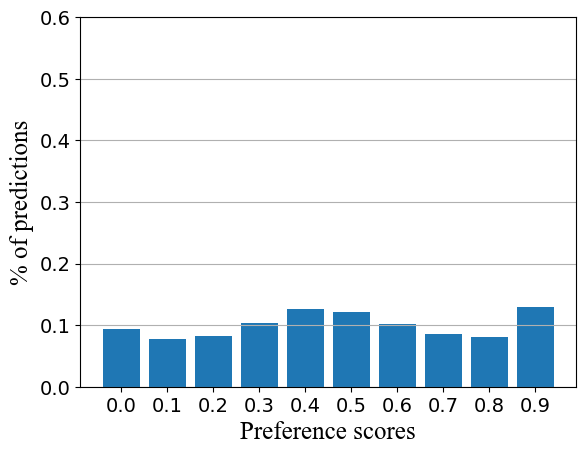

In [74]:
font2 = {'family': 'Times New Roman',
'weight': 'normal',
 'size': 18,
}

plt.bar(np.arange(len(values)), values)
plt.xticks(np.arange(10), np.arange(10)/10, size = 14)
plt.yticks(np.arange(7)/10, np.arange(7)/10, size=14)
plt.xlabel('Preference scores', font2)
plt.ylabel("% of predictions", font2)
plt.grid(axis="y")
plt.show()

# Hyper-Parameter TF

In [41]:
config['topks'] = [50]

In [42]:
file_path = './HyperParameter-FT/'

nce_lst = [0., 0.0001, 0.001, 0.01, 0.1, 1.0]
club_lst = [0., 0.0001, 0.001, 0.01, 0.1, 1.0]

HR_lst = []

for nce in nce_lst:
    for club in club_lst:
        seed_torch()

        config['decay_nce'] = nce
        config['decay_club'] = club
        #config['decay_lld'] = 10 * club

        weight_file = f"{is_sparse}_DPLSGT-reg_{config['decay_reg']}-dp_{config['decay_dp']}-kt_{config['decay_kt']}-nce_{config['decay_nce']}-club_{config['decay_club']}-Nc{config['n_cluster']}.pth.tar"


        #weight_file = f"{is_sparse}_DPLSGT-reg_{config['decay_reg']}-dp_{config['decay_dp']}-kt_{config['decay_kt']}-nce_{config['decay_nce']}-club_{config['decay_club']}-Nc{config['n_cluster']}.pth.tar"

        
        model = DPLSGT(config, UIGraph_lst, n_users_lst, m_items_lst, dict_item2vec_lst)
        model.load_state_dict(torch.load(file_path + weight_file)) 

        for i in range(N_domain):
            model.GraphEncoder[i].load_state_dict(torch.load(file_path + f'{i}_GraphEncoder' + weight_file))  

        for i in range(2):
            model.CLUBNet[i].load_state_dict(torch.load(file_path + f'{i}_CLUBNet' + weight_file)) 

        model.eval()

        HR_ave = []
        for i in range(len(n_users_lst)):
            test_results = Test(0, i, model)
            HR_ave.append(test_results['recall'][0])
            print("[TEST] Domain_{0} recall:{1}, ndcg:{2}".format(i, print_tense(test_results['recall'][0]), print_tense(test_results['ndcg'][0])))
        HR_lst.append(HR_ave)

[TEST] Domain_0 recall:0.064, ndcg:0.022
[TEST] Domain_1 recall:0.051, ndcg:0.018
[TEST] Domain_2 recall:0.107, ndcg:0.034
[TEST] Domain_3 recall:0.047, ndcg:0.016
[TEST] Domain_0 recall:0.065, ndcg:0.023
[TEST] Domain_1 recall:0.053, ndcg:0.018
[TEST] Domain_2 recall:0.205, ndcg:0.056
[TEST] Domain_3 recall:0.05, ndcg:0.016
[TEST] Domain_0 recall:0.07, ndcg:0.024
[TEST] Domain_1 recall:0.054, ndcg:0.019
[TEST] Domain_2 recall:0.206, ndcg:0.061
[TEST] Domain_3 recall:0.057, ndcg:0.019
[TEST] Domain_0 recall:0.066, ndcg:0.022
[TEST] Domain_1 recall:0.052, ndcg:0.017
[TEST] Domain_2 recall:0.244, ndcg:0.07
[TEST] Domain_3 recall:0.053, ndcg:0.017
[TEST] Domain_0 recall:0.036, ndcg:0.012
[TEST] Domain_1 recall:0.034, ndcg:0.011
[TEST] Domain_2 recall:0.252, ndcg:0.129
[TEST] Domain_3 recall:0.038, ndcg:0.012
[TEST] Domain_0 recall:0.032, ndcg:0.01
[TEST] Domain_1 recall:0.027, ndcg:0.007
[TEST] Domain_2 recall:0.167, ndcg:0.045
[TEST] Domain_3 recall:0.046, ndcg:0.013
[TEST] Domain_0 reca

In [43]:
import seaborn as sns
import matplotlib.pyplot as plt

In [21]:
HR_matrix = []
for i in range(6):
    HR_matrix.append(HR_lst[i*6:(i+1)*6])

## Dense Scenario

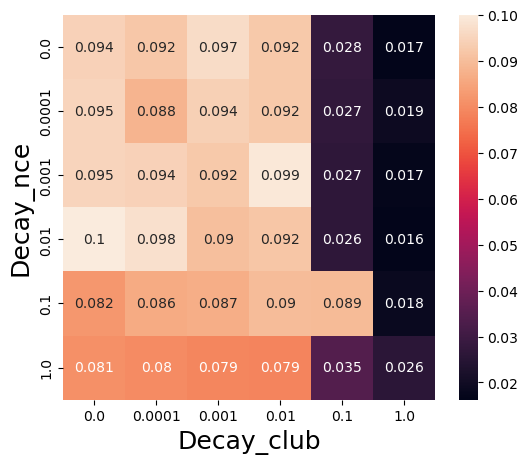

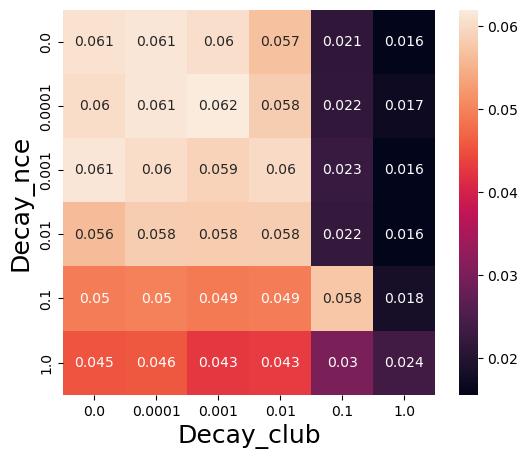

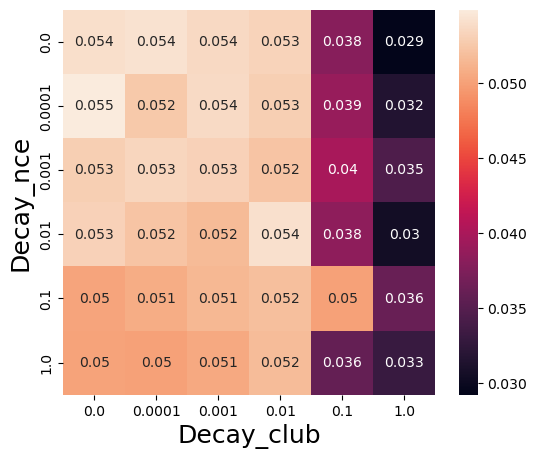

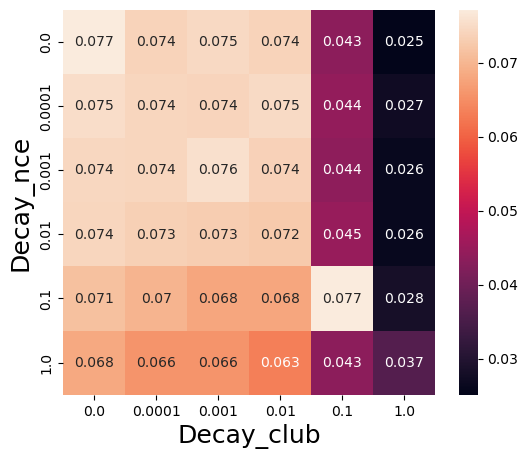

In [26]:
for i in range(4):
    y_labels = [0., 0.0001, 0.001, 0.01, 0.1, 1.0]
    x_labels = [0., 0.0001, 0.001, 0.01, 0.1, 1.0]

    plt.figure(figsize=(6, 5))
    sns.heatmap(np.array(HR_matrix)[:,:,i], annot=True, xticklabels=x_labels, yticklabels=y_labels)
    plt.xlabel('Decay_club',fontsize=18)
    plt.ylabel('Decay_nce',fontsize=18)
    plt.show()

In [27]:
np.array(HR_matrix).mean(2)

array([[0.07159821, 0.07033365, 0.07133412, 0.0690524 , 0.03273966,
        0.02162195],
       [0.07132824, 0.06900258, 0.07093374, 0.06959046, 0.03299648,
        0.02380451],
       [0.07092152, 0.07053383, 0.07000352, 0.07123355, 0.03318351,
        0.0233226 ],
       [0.07091518, 0.07040836, 0.06826433, 0.0691828 , 0.03295301,
        0.02220395],
       [0.0632883 , 0.06403102, 0.06383623, 0.06467364, 0.06853571,
        0.02528642],
       [0.06116142, 0.06033482, 0.05942857, 0.05913322, 0.03602091,
        0.02986043]])

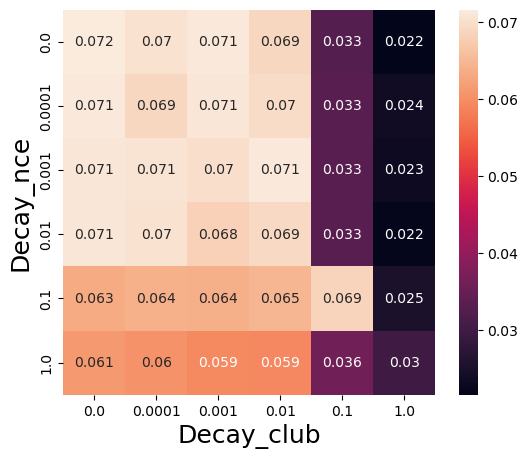

In [28]:
y_labels = [0., 0.0001, 0.001, 0.01, 0.1, 1.0]
x_labels = [0., 0.0001, 0.001, 0.01, 0.1, 1.0]

plt.figure(figsize=(6, 5))
sns.heatmap(np.array(HR_matrix).mean(2), annot=True, xticklabels=x_labels, yticklabels=y_labels)
plt.xlabel('Decay_club',fontsize=18)
plt.ylabel('Decay_nce',fontsize=18)
plt.show()

## Sparse scenario

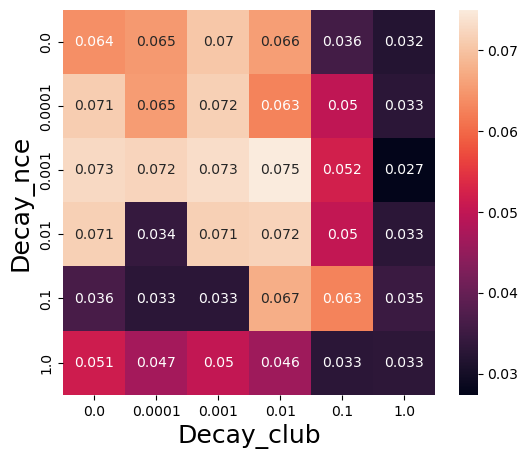

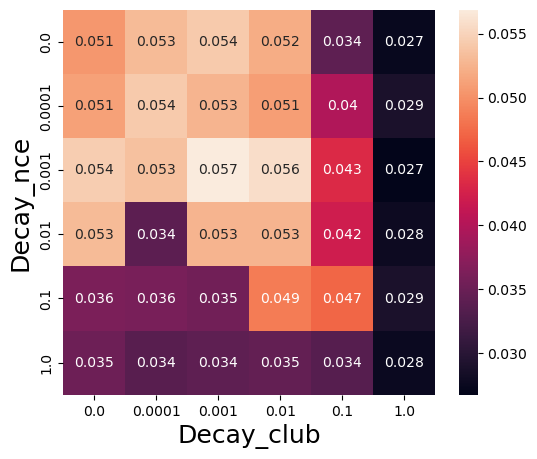

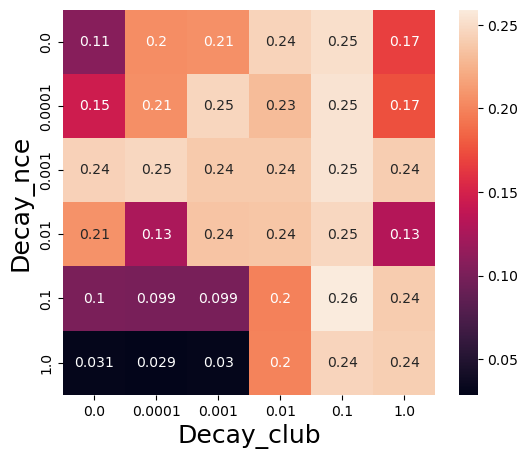

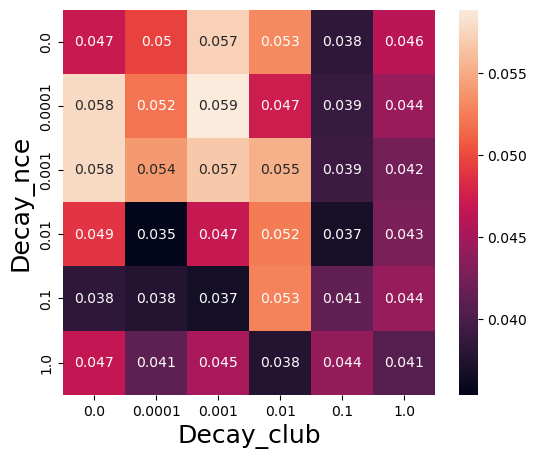

In [45]:
HR_matrix = []
for i in range(6):
    HR_matrix.append(HR_lst[i*6:(i+1)*6])

for i in range(4):
    y_labels = [0., 0.0001, 0.001, 0.01, 0.1, 1.0]
    x_labels = [0., 0.0001, 0.001, 0.01, 0.1, 1.0]

    plt.figure(figsize=(6, 5))
    sns.heatmap(np.array(HR_matrix)[:,:,i], annot=True, xticklabels=x_labels, yticklabels=y_labels)
    plt.xlabel('Decay_club',fontsize=18)
    plt.ylabel('Decay_nce',fontsize=18)
    plt.show()

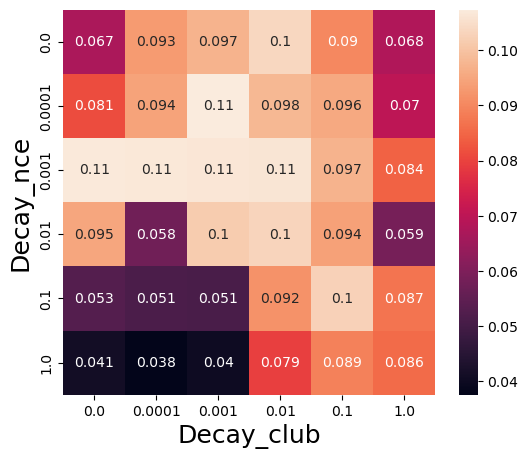

In [46]:
y_labels = [0., 0.0001, 0.001, 0.01, 0.1, 1.0]
x_labels = [0., 0.0001, 0.001, 0.01, 0.1, 1.0]

plt.figure(figsize=(6, 5))
sns.heatmap(np.array(HR_matrix).mean(2), annot=True, xticklabels=x_labels, yticklabels=y_labels)
plt.xlabel('Decay_club',fontsize=18)
plt.ylabel('Decay_nce',fontsize=18)
plt.show()

# Danse

In [29]:
config['topks'] = [i*10 for i in range(10)]

In [35]:
print("Is_sparse:", is_sparse)

nce_lst = [0., 0.0001, 0.001, 0.01, 0.1, 1.0]

for nce in nce_lst:
    print()
    print("====================================================================================================")
    print("NCE:", nce)
    config['decay_nce'] = nce
    
    file_path = './HyperParameter-FT/'
    #weight_file = f"DPLSGT-LGC3-Reg_{config['decay_reg']}-Rec_{config['decay_dp']}-Kt_{config['decay_kt']}-{config['latent_dim_rec']}-N_c{config['n_cluster']}.pth.tar"

    #weight_file = f"DPLSGT-reg_{config['decay_reg']}-dp_{config['decay_dp']}-kt_{config['decay_kt']}-nce_{config['decay_nce']}-club_{config['decay_club']}-Nc{config['n_cluster']}.pth.tar"

    weight_file = f"{is_sparse}_DPLSGT-reg_{config['decay_reg']}-dp_{config['decay_dp']}-kt_{config['decay_kt']}-nce_{config['decay_nce']}-club_{config['decay_club']}-Nc{config['n_cluster']}.pth.tar"

    model = DPLSGT(config, UIGraph_lst, n_users_lst, m_items_lst, dict_item2vec_lst)
    model.load_state_dict(torch.load(file_path + weight_file)) 

    for i in range(N_domain):
        model.GraphEncoder[i].load_state_dict(torch.load(file_path + f'{i}_GraphEncoder' + weight_file))  

    for i in range(2):
        model.CLUBNet[i].load_state_dict(torch.load(file_path + f'{i}_CLUBNet' + weight_file)) 

    model.eval()

    HR = []
    NDCG = []
    for domain_index in range(N_domain): 
        results = Test(0, domain_index, model)

        print("Recall:", end="  ")
        for i in range(len(results['recall'])):
            print(str(np.around(results['recall'][i], 3)), end=", ")

        print("ndcg:", end="  ")
        for i in range(len(results['ndcg'])):
            print(str(np.around(results['ndcg'][i], 3)), end=", ")

        print()   
        print("----------------------------------------------")    
        HR.append(results['recall'])
        NDCG.append(results['ndcg'])

    ave_HR = np.around(np.array(HR).mean(axis=0), 3)
    ave_NDCG = np.around(np.array(NDCG).mean(axis=0), 3)

    print("HR_ave:", end="  ")
    for i in range(len(ave_HR)):
        print(f'{ave_HR[i]}', end=", ")

    print()
    print("HR_ave:", end="  ")
    for i in range(len(ave_NDCG)):
        print(f'{ave_NDCG[i]}', end=", ")    
    # Result_of Sparse Domains

Is_sparse: 0

NCE: 0.0


C:\Users\psy62\AppData\Local\Temp\ipykernel_23176\3099096734.py:42: RuntimeWarning: invalid value encountered in double_scalars
  precis = np.sum(right_pred)/precis_n


Recall:  0.0, 0.012, 0.027, 0.038, 0.05, 0.059, 0.066, 0.074, 0.08, 0.087, ndcg:  0.0, 0.006, 0.01, 0.012, 0.014, 0.016, 0.017, 0.018, 0.019, 0.021, 
----------------------------------------------
Recall:  0.0, 0.008, 0.016, 0.024, 0.032, 0.038, 0.044, 0.05, 0.056, 0.063, ndcg:  0.0, 0.003, 0.006, 0.007, 0.009, 0.01, 0.011, 0.012, 0.013, 0.014, 
----------------------------------------------
Recall:  0.0, 0.024, 0.033, 0.039, 0.044, 0.048, 0.052, 0.054, 0.058, 0.063, ndcg:  0.0, 0.013, 0.015, 0.016, 0.017, 0.018, 0.019, 0.019, 0.02, 0.021, 
----------------------------------------------
Recall:  0.0, 0.014, 0.028, 0.042, 0.052, 0.062, 0.073, 0.079, 0.086, 0.095, ndcg:  0.0, 0.007, 0.01, 0.013, 0.015, 0.017, 0.018, 0.019, 0.021, 0.022, 
----------------------------------------------
HR_ave:  0.0, 0.015, 0.026, 0.036, 0.045, 0.052, 0.059, 0.064, 0.07, 0.077, 
HR_ave:  0.0, 0.007, 0.01, 0.012, 0.014, 0.015, 0.016, 0.017, 0.018, 0.019, 
NCE: 0.0001
Recall:  0.0, 0.014, 0.029, 0.04, 0.05, 0

In [26]:
print("Is_sparse:", is_sparse)

club_lst = [0., 0.0001, 0.001, 0.01, 0.1, 1.0]

for club in club_lst:
    print()
    print("====================================================================================================")
    print("club:", club)
    config['decay_club'] = club
    config['decay_lld'] = 10 * club
    
    file_path = './HyperParameter-FT/'
    #weight_file = f"DPLSGT-LGC3-Reg_{config['decay_reg']}-Rec_{config['decay_dp']}-Kt_{config['decay_kt']}-{config['latent_dim_rec']}-N_c{config['n_cluster']}.pth.tar"

    #weight_file = f"DPLSGT-reg_{config['decay_reg']}-dp_{config['decay_dp']}-kt_{config['decay_kt']}-nce_{config['decay_nce']}-club_{config['decay_club']}-Nc{config['n_cluster']}.pth.tar"

    weight_file = f"{is_sparse}_DPLSGT-reg_{config['decay_reg']}-dp_{config['decay_dp']}-kt_{config['decay_kt']}-nce_{config['decay_nce']}-club_{config['decay_club']}-Nc{config['n_cluster']}.pth.tar"

    model = DPLSGT(config, UIGraph_lst, n_users_lst, m_items_lst, dict_item2vec_lst)
    model.load_state_dict(torch.load(file_path + weight_file)) 

    for i in range(N_domain):
        model.GraphEncoder[i].load_state_dict(torch.load(file_path + f'{i}_GraphEncoder' + weight_file))  

    for i in range(2):
        model.CLUBNet[i].load_state_dict(torch.load(file_path + f'{i}_CLUBNet' + weight_file)) 

    model.eval()

    HR = []
    NDCG = []
    for domain_index in range(N_domain): 
        results = Test(0, domain_index, model)

        print("Recall:", end="  ")
        for i in range(len(results['recall'])):
            print(str(np.around(results['recall'][i], 3)), end=", ")

        print("ndcg:", end="  ")
        for i in range(len(results['ndcg'])):
            print(str(np.around(results['ndcg'][i], 3)), end=", ")

        print()   
        print("----------------------------------------------")    
        HR.append(results['recall'])
        NDCG.append(results['ndcg'])

    ave_HR = np.around(np.array(HR).mean(axis=0), 3)
    ave_NDCG = np.around(np.array(NDCG).mean(axis=0), 3)

    print("HR_ave:", end="  ")
    for i in range(len(ave_HR)):
        print(f'{ave_HR[i]}', end=", ")

    print()
    print("HR_ave:", end="  ")
    for i in range(len(ave_NDCG)):
        print(f'{ave_NDCG[i]}', end=", ")    
    # Result_of Sparse Domains

Is_sparse: 0

club: 0.0


C:\Users\psy62\AppData\Local\Temp\ipykernel_23176\3099096734.py:42: RuntimeWarning: invalid value encountered in double_scalars
  precis = np.sum(right_pred)/precis_n


Recall:  0.0, 0.014, 0.026, 0.036, 0.046, 0.055, 0.063, 0.07, 0.078, 0.084, ndcg:  0.0, 0.006, 0.009, 0.012, 0.014, 0.015, 0.016, 0.018, 0.019, 0.02, 
----------------------------------------------
Recall:  0.0, 0.008, 0.016, 0.024, 0.03, 0.037, 0.042, 0.047, 0.053, 0.059, ndcg:  0.0, 0.004, 0.006, 0.007, 0.008, 0.01, 0.01, 0.011, 0.012, 0.013, 
----------------------------------------------
Recall:  0.0, 0.022, 0.032, 0.038, 0.042, 0.046, 0.05, 0.054, 0.057, 0.06, ndcg:  0.0, 0.012, 0.014, 0.016, 0.017, 0.017, 0.018, 0.018, 0.019, 0.019, 
----------------------------------------------
Recall:  0.0, 0.014, 0.026, 0.038, 0.05, 0.06, 0.068, 0.076, 0.083, 0.09, ndcg:  0.0, 0.006, 0.009, 0.012, 0.014, 0.016, 0.017, 0.019, 0.02, 0.021, 
----------------------------------------------
HR_ave:  0.0, 0.014, 0.025, 0.034, 0.042, 0.05, 0.056, 0.062, 0.068, 0.073, 
HR_ave:  0.0, 0.007, 0.01, 0.012, 0.013, 0.014, 0.016, 0.017, 0.018, 0.018, 
club: 0.0001
Recall:  0.0, 0.013, 0.024, 0.035, 0.044, 0.

# Sparse

In [24]:
config['topks'] = [i*10 for i in range(10)]

In [35]:
print("Is_sparse:", is_sparse)

nce_lst = [0., 0.0001, 0.001, 0.01, 0.1, 1.0]

for nce in nce_lst:
    print()
    print("====================================================================================================")
    print("NCE:", nce)
    config['decay_nce'] = nce
    
    file_path = './HyperParameter-FT/'
    #weight_file = f"DPLSGT-LGC3-Reg_{config['decay_reg']}-Rec_{config['decay_dp']}-Kt_{config['decay_kt']}-{config['latent_dim_rec']}-N_c{config['n_cluster']}.pth.tar"

    #weight_file = f"DPLSGT-reg_{config['decay_reg']}-dp_{config['decay_dp']}-kt_{config['decay_kt']}-nce_{config['decay_nce']}-club_{config['decay_club']}-Nc{config['n_cluster']}.pth.tar"

    weight_file = f"{is_sparse}_DPLSGT-reg_{config['decay_reg']}-dp_{config['decay_dp']}-kt_{config['decay_kt']}-nce_{config['decay_nce']}-club_{config['decay_club']}-Nc{config['n_cluster']}.pth.tar"

    model = DPLSGT(config, UIGraph_lst, n_users_lst, m_items_lst, dict_item2vec_lst)
    model.load_state_dict(torch.load(file_path + weight_file)) 

    for i in range(N_domain):
        model.GraphEncoder[i].load_state_dict(torch.load(file_path + f'{i}_GraphEncoder' + weight_file))  

    for i in range(2):
        model.CLUBNet[i].load_state_dict(torch.load(file_path + f'{i}_CLUBNet' + weight_file)) 

    model.eval()

    HR = []
    NDCG = []
    for domain_index in range(N_domain): 
        results = Test(0, domain_index, model)

        print("Recall:", end="  ")
        for i in range(len(results['recall'])):
            print(str(np.around(results['recall'][i], 3)), end=", ")

        print("ndcg:", end="  ")
        for i in range(len(results['ndcg'])):
            print(str(np.around(results['ndcg'][i], 3)), end=", ")

        print()   
        print("----------------------------------------------")    
        HR.append(results['recall'])
        NDCG.append(results['ndcg'])

    ave_HR = np.around(np.array(HR).mean(axis=0), 3)
    ave_NDCG = np.around(np.array(NDCG).mean(axis=0), 3)

    print("HR_ave:", end="  ")
    for i in range(len(ave_HR)):
        print(f'{ave_HR[i]}', end=", ")

    print()
    print("HR_ave:", end="  ")
    for i in range(len(ave_NDCG)):
        print(f'{ave_NDCG[i]}', end=", ")    
    # Result_of Sparse Domains

Is_sparse: 1

NCE: 0.0


C:\Users\psy62\AppData\Local\Temp\ipykernel_21536\3099096734.py:42: RuntimeWarning: invalid value encountered in double_scalars
  precis = np.sum(right_pred)/precis_n


Recall:  0.0, 0.029, 0.044, 0.056, 0.064, 0.072, 0.08, 0.087, 0.091, 0.096, ndcg:  0.0, 0.015, 0.019, 0.021, 0.023, 0.024, 0.026, 0.027, 0.028, 0.028, 
----------------------------------------------
Recall:  0.0, 0.021, 0.031, 0.038, 0.046, 0.054, 0.06, 0.066, 0.071, 0.075, ndcg:  0.0, 0.012, 0.014, 0.016, 0.017, 0.019, 0.02, 0.021, 0.021, 0.022, 
----------------------------------------------
Recall:  0.0, 0.093, 0.226, 0.232, 0.244, 0.248, 0.268, 0.27, 0.274, 0.275, ndcg:  0.0, 0.039, 0.073, 0.075, 0.077, 0.077, 0.081, 0.081, 0.082, 0.082, 
----------------------------------------------
Recall:  0.0, 0.02, 0.032, 0.044, 0.05, 0.058, 0.066, 0.072, 0.078, 0.082, ndcg:  0.0, 0.01, 0.013, 0.015, 0.016, 0.018, 0.019, 0.02, 0.021, 0.022, 
----------------------------------------------
HR_ave:  0.0, 0.041, 0.083, 0.093, 0.101, 0.108, 0.118, 0.124, 0.128, 0.132, 
HR_ave:  0.0, 0.019, 0.03, 0.032, 0.033, 0.035, 0.036, 0.037, 0.038, 0.039, 
NCE: 0.0001
Recall:  0.0, 0.028, 0.043, 0.056, 0.064,

In [47]:
print("Is_sparse:", is_sparse)

club_lst = [0., 0.0001, 0.001, 0.01, 0.1, 1.0]

for club in club_lst:
    print()
    print("====================================================================================================")
    print("club:", club)
    config['decay_club'] = club
    config['decay_lld'] = 10 * club
    
    file_path = './HyperParameter-FT/'
    #weight_file = f"DPLSGT-LGC3-Reg_{config['decay_reg']}-Rec_{config['decay_dp']}-Kt_{config['decay_kt']}-{config['latent_dim_rec']}-N_c{config['n_cluster']}.pth.tar"

    #weight_file = f"DPLSGT-reg_{config['decay_reg']}-dp_{config['decay_dp']}-kt_{config['decay_kt']}-nce_{config['decay_nce']}-club_{config['decay_club']}-Nc{config['n_cluster']}.pth.tar"

    weight_file = f"{is_sparse}_DPLSGT-reg_{config['decay_reg']}-dp_{config['decay_dp']}-kt_{config['decay_kt']}-nce_{config['decay_nce']}-club_{config['decay_club']}-Nc{config['n_cluster']}.pth.tar"

    model = DPLSGT(config, UIGraph_lst, n_users_lst, m_items_lst, dict_item2vec_lst)
    model.load_state_dict(torch.load(file_path + weight_file)) 

    for i in range(N_domain):
        model.GraphEncoder[i].load_state_dict(torch.load(file_path + f'{i}_GraphEncoder' + weight_file))  

    for i in range(2):
        model.CLUBNet[i].load_state_dict(torch.load(file_path + f'{i}_CLUBNet' + weight_file)) 

    model.eval()

    HR = []
    NDCG = []
    for domain_index in range(N_domain): 
        results = Test(0, domain_index, model)

        print("Recall:", end="  ")
        for i in range(len(results['recall'])):
            print(str(np.around(results['recall'][i], 3)), end=", ")

        print("ndcg:", end="  ")
        for i in range(len(results['ndcg'])):
            print(str(np.around(results['ndcg'][i], 3)), end=", ")

        print()   
        print("----------------------------------------------")    
        HR.append(results['recall'])
        NDCG.append(results['ndcg'])

    ave_HR = np.around(np.array(HR).mean(axis=0), 3)
    ave_NDCG = np.around(np.array(NDCG).mean(axis=0), 3)

    print("HR_ave:", end="  ")
    for i in range(len(ave_HR)):
        print(f'{ave_HR[i]}', end=", ")

    print()
    print("HR_ave:", end="  ")
    for i in range(len(ave_NDCG)):
        print(f'{ave_NDCG[i]}', end=", ")    
    # Result_of Sparse Domains

Is_sparse: 1

club: 0.0


C:\Users\psy62\AppData\Local\Temp\ipykernel_21536\3099096734.py:42: RuntimeWarning: invalid value encountered in double_scalars
  precis = np.sum(right_pred)/precis_n


Recall:  0.0, 0.029, 0.042, 0.052, 0.06, 0.066, 0.074, 0.08, 0.085, 0.09, ndcg:  0.0, 0.015, 0.019, 0.021, 0.022, 0.023, 0.025, 0.026, 0.027, 0.027, 
----------------------------------------------
Recall:  0.0, 0.02, 0.032, 0.04, 0.048, 0.054, 0.06, 0.067, 0.071, 0.076, ndcg:  0.0, 0.011, 0.014, 0.016, 0.017, 0.018, 0.019, 0.02, 0.021, 0.022, 
----------------------------------------------
Recall:  0.0, 0.039, 0.099, 0.104, 0.108, 0.11, 0.119, 0.121, 0.167, 0.214, ndcg:  0.0, 0.019, 0.035, 0.036, 0.037, 0.037, 0.038, 0.039, 0.046, 0.053, 
----------------------------------------------
Recall:  0.0, 0.02, 0.03, 0.037, 0.046, 0.052, 0.058, 0.066, 0.071, 0.076, ndcg:  0.0, 0.011, 0.013, 0.015, 0.016, 0.017, 0.018, 0.02, 0.021, 0.021, 
----------------------------------------------
HR_ave:  0.0, 0.027, 0.05, 0.058, 0.066, 0.07, 0.078, 0.084, 0.099, 0.114, 
HR_ave:  0.0, 0.014, 0.02, 0.022, 0.023, 0.024, 0.025, 0.026, 0.029, 0.031, 
club: 0.0001
Recall:  0.0, 0.03, 0.042, 0.054, 0.063, 0.07

# Result

In [47]:
config['topks'] = [i*10 for i in range(10)]

In [48]:
print("Is_sparse:", is_sparse)

config['decay_nce'] = 0.001
config['decay_club'] = 0.01

file_path = './HyperParameter-FT/'

weight_file = f"{is_sparse}_DPLSGT-reg_{config['decay_reg']}-dp_{config['decay_dp']}-kt_{config['decay_kt']}-nce_{config['decay_nce']}-club_{config['decay_club']}-Nc{config['n_cluster']}.pth.tar"

model = DPLSGT(config, UIGraph_lst, n_users_lst, m_items_lst, dict_item2vec_lst)
model.load_state_dict(torch.load(file_path + weight_file)) 

for i in range(N_domain):
    model.GraphEncoder[i].load_state_dict(torch.load(file_path + f'{i}_GraphEncoder' + weight_file))  

for i in range(2):
    model.CLUBNet[i].load_state_dict(torch.load(file_path + f'{i}_CLUBNet' + weight_file)) 
    
model.eval()

HR = []
NDCG = []
for domain_index in range(N_domain): 
    results = Test(0, domain_index, model)
    
    print("Recall:", end="  ")
    for i in range(len(results['recall'])):
        print(str(np.around(results['recall'][i], 3)), end=", ")
        
    print("ndcg:", end="  ")
    for i in range(len(results['ndcg'])):
        print(str(np.around(results['ndcg'][i], 3)), end=", ")
        
    print()   
    print("----------------------------------------------")    
    HR.append(results['recall'])
    NDCG.append(results['ndcg'])

ave_HR = np.around(np.array(HR).mean(axis=0), 3)
ave_NDCG = np.around(np.array(NDCG).mean(axis=0), 3)

print("HR_ave:", end="  ")
for i in range(len(ave_HR)):
    print(f'{ave_HR[i]}', end=", ")

print()
print("HR_ave:", end="  ")
for i in range(len(ave_NDCG)):
    print(f'{ave_NDCG[i]}', end=", ")    
# Result_of Sparse Domains

Is_sparse: 1


C:\Users\psy62\AppData\Local\Temp\ipykernel_46128\3099096734.py:42: RuntimeWarning: invalid value encountered in double_scalars
  precis = np.sum(right_pred)/precis_n


Recall:  0.0, 0.03, 0.045, 0.057, 0.066, 0.075, 0.082, 0.088, 0.094, 0.1, ndcg:  0.0, 0.016, 0.02, 0.022, 0.024, 0.026, 0.027, 0.028, 0.029, 0.03, 
----------------------------------------------
Recall:  0.0, 0.022, 0.033, 0.042, 0.05, 0.056, 0.061, 0.066, 0.071, 0.075, ndcg:  0.0, 0.012, 0.014, 0.016, 0.018, 0.019, 0.02, 0.021, 0.021, 0.022, 
----------------------------------------------
Recall:  0.0, 0.181, 0.187, 0.23, 0.235, 0.239, 0.241, 0.252, 0.255, 0.258, ndcg:  0.0, 0.079, 0.08, 0.09, 0.091, 0.091, 0.092, 0.094, 0.094, 0.095, 
----------------------------------------------
Recall:  0.0, 0.021, 0.032, 0.042, 0.049, 0.055, 0.063, 0.068, 0.074, 0.08, ndcg:  0.0, 0.011, 0.013, 0.015, 0.017, 0.018, 0.019, 0.02, 0.021, 0.022, 
----------------------------------------------
HR_ave:  0.0, 0.063, 0.074, 0.093, 0.1, 0.106, 0.112, 0.118, 0.123, 0.128, 
HR_ave:  0.0, 0.029, 0.032, 0.036, 0.037, 0.038, 0.039, 0.041, 0.041, 0.042, 

In [30]:
config['topks'] = [i*10 for i in range(10)]

In [31]:
print("Is_sparse:", is_sparse)

config['decay_nce'] = 0.001
config['decay_club'] = 0.01

file_path = './HyperParameter-FT/'

weight_file = f"{is_sparse}_DPLSGT-reg_{config['decay_reg']}-dp_{config['decay_dp']}-kt_{config['decay_kt']}-nce_{config['decay_nce']}-club_{config['decay_club']}-Nc{config['n_cluster']}.pth.tar"

model = DPLSGT(config, UIGraph_lst, n_users_lst, m_items_lst, dict_item2vec_lst)
model.load_state_dict(torch.load(file_path + weight_file)) 

for i in range(N_domain):
    model.GraphEncoder[i].load_state_dict(torch.load(file_path + f'{i}_GraphEncoder' + weight_file))  

for i in range(2):
    model.CLUBNet[i].load_state_dict(torch.load(file_path + f'{i}_CLUBNet' + weight_file)) 
    
model.eval()

HR = []
NDCG = []
for domain_index in range(N_domain): 
    results = Test(0, domain_index, model)
    
    print("Recall:", end="  ")
    for i in range(len(results['recall'])):
        print(str(np.around(results['recall'][i], 3)), end=", ")
        
    print("ndcg:", end="  ")
    for i in range(len(results['ndcg'])):
        print(str(np.around(results['ndcg'][i], 3)), end=", ")
        
    print()   
    print("----------------------------------------------")    
    HR.append(results['recall'])
    NDCG.append(results['ndcg'])

ave_HR = np.around(np.array(HR).mean(axis=0), 3)
ave_NDCG = np.around(np.array(NDCG).mean(axis=0), 3)

print("HR_ave:", end="  ")
for i in range(len(ave_HR)):
    print(f'{ave_HR[i]}', end=", ")

print()
print("HR_ave:", end="  ")
for i in range(len(ave_NDCG)):
    print(f'{ave_NDCG[i]}', end=", ")    
# Result_of Sparse Domains

Is_sparse: 0


C:\Users\psy62\AppData\Local\Temp\ipykernel_38088\3099096734.py:42: RuntimeWarning: invalid value encountered in double_scalars
  precis = np.sum(right_pred)/precis_n


Recall:  0.0, 0.033, 0.056, 0.075, 0.088, 0.099, 0.109, 0.117, 0.123, 0.131, ndcg:  0.0, 0.016, 0.021, 0.025, 0.028, 0.03, 0.031, 0.033, 0.034, 0.035, 
----------------------------------------------
Recall:  0.0, 0.02, 0.035, 0.044, 0.052, 0.06, 0.066, 0.072, 0.078, 0.083, ndcg:  0.0, 0.01, 0.013, 0.015, 0.017, 0.018, 0.019, 0.02, 0.021, 0.022, 
----------------------------------------------
Recall:  0.0, 0.027, 0.038, 0.043, 0.048, 0.052, 0.057, 0.06, 0.064, 0.067, ndcg:  0.0, 0.013, 0.015, 0.016, 0.017, 0.018, 0.019, 0.02, 0.02, 0.021, 
----------------------------------------------
Recall:  0.0, 0.024, 0.04, 0.053, 0.065, 0.074, 0.084, 0.092, 0.098, 0.105, ndcg:  0.0, 0.012, 0.016, 0.018, 0.021, 0.022, 0.024, 0.025, 0.026, 0.028, 
----------------------------------------------
HR_ave:  0.0, 0.026, 0.042, 0.054, 0.063, 0.071, 0.079, 0.085, 0.091, 0.097, 
HR_ave:  0.0, 0.012, 0.016, 0.019, 0.021, 0.022, 0.023, 0.025, 0.025, 0.026, 